# Libs utilizadas

In [422]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import statsmodels.api as sm
import scipy
from scipy.stats import boxcox
from datetime import datetime
from math import sqrt
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pyplot import figure
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Filtrando warnings
warnings.filterwarnings("ignore")

___

# 1 - Organização dos Dados
> Filtragem da base de dados

Carregando a base bruta

In [423]:
df = pd.read_csv('desepesa_2018_2024.csv', encoding='latin1', sep=';')

In [424]:
df.columns

Index(['ANO', 'PODER', 'UO', 'DESCRICAO_UO', 'UG', 'DESCRICAO_UG', 'FUNCAO', 'DESCRICAO_FUNCAO', 'SUB_FUNCAO', 'DESCRICAO_SUB_FUNCAO', 'PROGRAMA', 'PROGRAMA_DESCRICAO', 'PROJETO', 'PROJETO_DESCRICAO', 'PT', 'PT_DESCRICAO', 'FONTE_MAE', 'DESCRICAO_FONTE_MAE', 'FONTE', 'DESCRICAO_FONTE', 'NATUREZA1', 'DESCRICAO_NATUREZA1', 'NATUREZA2', 'DESCRICAO_NATUREZA2', 'NATUREZA3', 'DESCRICAO_NATUREZA3', 'NATUREZA4', 'DESCRICAO_NATUREZA4', 'NATUREZA5', 'DESCRICAO_NATUREZA5', 'NATUREZA6', 'DESCRICAO_NATUREZA6', 'NATUREZA', 'DESCRICAO_NATUREZA', 'CODIGO_FAVORECIDO', 'NOME_FAVORECIDO', 'COD_TIPO_LICITACAO', 'TIPO_LICITACAO', 'MES', 'VALOR_EMPENHADO', 'VALOR_LIQUIDADO', 'VALOR_PAGO'], dtype='object')

Organizando a base

Selecionando as colunas para análise

In [425]:
new_var = df[['NATUREZA3', 'DESCRICAO_NATUREZA3']].drop_duplicates()
print(new_var)

      NATUREZA3         DESCRICAO_NATUREZA3
0     333000000   OUTRAS DESPESAS CORRENTES
2     344000000               INVESTIMENTOS
16    331000000  PESSOAL E ENCARGOS SOCIAIS
175   346000000       AMORTIZACAO DA DIVIDA
431   332000000  JUROS E ENCARGOS DA DIVIDA
5674  345000000       INVERSOES FINANCEIRAS


In [426]:
# Colunas importantes: ANO, MES, UO, UG, FONTE_MAE, NATUREZA, VALOR_EMPENHADO, VALOR_LIQUIDADO, VALOR_PAGO
df_test = df[['ANO', 'MES', 'PODER','UO', 'UG', 'FONTE_MAE', 'NATUREZA3', 'VALOR_EMPENHADO']]

Criação de uma coluna Ano e Mês

In [427]:
df_test_2024.head()

,ANO_MES,VALOR_EMPENHADO


In [428]:
df_test['ANO_MES'] = df_test['ANO'].astype(str) + '-' + df_test['MES'].astype(str)

#### Filtro dos dados!
Definições: 
Unidade Gestora.  
Natureza.  
Poder.  

**FIltro de maior relevância!**

In [429]:
# UO == 21018, NATURZA3 == 331000000, PODER == 'EXE'
# SEFAZ, DESPESA COM PESSOAL E PODER EXECUTIVO
# df_test = df_test[df_test['UO'] == 21018]
# df_test = df_test[df_test['NATUREZA3'] == 331000000] # Filtrando a Natureza de Pessoal de Operação
df_test = df_test[df_test['PODER'] == 'EXE'] # Apenas o poder executivo

In [430]:
df_test = df_test.sort_values(by=['ANO', 'MES']).reset_index(drop=True)

In [431]:
# Transformando em 'Object' ANO, MES, PODER, UO, UG, FONTE_MAE, NATUREZA3.
convertendo_obj = ['ANO', 'MES', 'PODER', 'UO', 'UG', 'FONTE_MAE', 'NATUREZA3']
for column in convertendo_obj:
    df_test[column] = df_test[column].astype('object')

In [432]:
# Convertendo para Datetime ANO_MES 
df_test['ANO_MES'] = pd.to_datetime(df_test['ANO_MES'], format='%Y-%m')

> Verificação descritiva antes de AGRUPAR!

In [433]:
df_test['VALOR_EMPENHADO'].describe()

count    4.782040e+05
mean     1.708538e+05
std      2.074060e+06
min     -1.448292e+08
25%      4.000000e+01
50%      1.230000e+03
75%      1.156436e+04
max      2.000000e+08
Name: VALOR_EMPENHADO, dtype: float64

> Verificação de valor nulo ou ausente

In [434]:
df_valores_ruins = df_test[df_test['VALOR_EMPENHADO'] <= 0]
print(f'Quantidade de valores ruins: {df_valores_ruins.shape[0]}')
print(f'quantidade de vaores negativos: {df_valores_ruins[df_valores_ruins["VALOR_EMPENHADO"] < 0].shape[0]}')
print(f'quantidade de valores 0: {df_valores_ruins[df_valores_ruins["VALOR_EMPENHADO"] == 0].shape[0]}')

Quantidade de valores ruins: 115188
quantidade de vaores negativos: 16811
quantidade de valores 0: 98377


In [435]:
df_test.shape

(478204, 9)

In [436]:
quantidade_de_valor_ausente = df_test['VALOR_EMPENHADO'].isnull().sum().sum()
print(f'Quantidade de valores ausentes: {quantidade_de_valor_ausente}')

Quantidade de valores ausentes: 0


In [437]:
df_test['VALOR_EMPENHADO'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 478204 entries, 0 to 478203
Series name: VALOR_EMPENHADO
Non-Null Count   Dtype  
--------------   -----  
478204 non-null  float64
dtypes: float64(1)
memory usage: 3.6 MB


> Verificação da porcentagem de valores atribuidos com '0'.

In [438]:
# Caclular a porcentagem de valores 0 em realcao ao total
porcentagem_de_zeros = df_test[df_test['VALOR_EMPENHADO'] == 0].shape[0] / df_test.shape[0] * 100
print(f'Porcetagem de valores 0: {porcentagem_de_zeros:.2f}%')

Porcetagem de valores 0: 20.57%



> Agrupando os dados na frêquencia 'MENSAL'.

In [439]:
# Agrupando
df_test_agrupado = df_test.groupby('ANO_MES')['VALOR_EMPENHADO'].sum().reset_index()

In [420]:
df_test_2024.head()

,ANO_MES,VALOR_EMPENHADO


In [312]:
dados = df_test_agrupado.copy()

> ! Setembro ainda não encerrou, então foi retirado da análise!

In [313]:
# Setembro não acabou, então não temos o valor oficial de setembro de 2024
dados = dados[:-1]

In [314]:
# Setando o index
dados.index = dados['ANO_MES']
# dados.drop('ANO_MES', axis=1, inplace=True)

In [315]:
dados.head()

,ANO_MES,VALOR_EMPENHADO
ANO_MES,,
2018-01-01,2018-01-01,6.361822e+08
2018-02-01,2018-02-01,6.445037e+08
2018-03-01,2018-03-01,1.037755e+09
2018-04-01,2018-04-01,8.493252e+08
2018-05-01,2018-05-01,8.033304e+08


In [316]:
dados.tail()

,ANO_MES,VALOR_EMPENHADO
ANO_MES,,
2024-04-01,2024-04-01,1.387101e+09
2024-05-01,2024-05-01,1.345654e+09
2024-06-01,2024-06-01,1.379791e+09
2024-07-01,2024-07-01,1.372170e+09
2024-08-01,2024-08-01,1.260058e+09


> Dados está pronto para ser análisado

___

# 2 - Análise

Formatação Gŕafica - Padrão

In [317]:
# Formatação para gráficos e tabelas
plt.style.use('ggplot')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500 )
pd.set_option('display.width', 1000)

In [318]:
# Formatando os Labels
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

> Atribuindo a coluna responsável pela 'data' como index, tornando o df em uma series

Então:  
dados = Dataframe  
dados_serie = Series

Visualização gráfica desses dados

In [319]:
dados.head()

,ANO_MES,VALOR_EMPENHADO
ANO_MES,,
2018-01-01,2018-01-01,6.361822e+08
2018-02-01,2018-02-01,6.445037e+08
2018-03-01,2018-03-01,1.037755e+09
2018-04-01,2018-04-01,8.493252e+08
2018-05-01,2018-05-01,8.033304e+08


<Axes: xlabel='ANO_MES'>

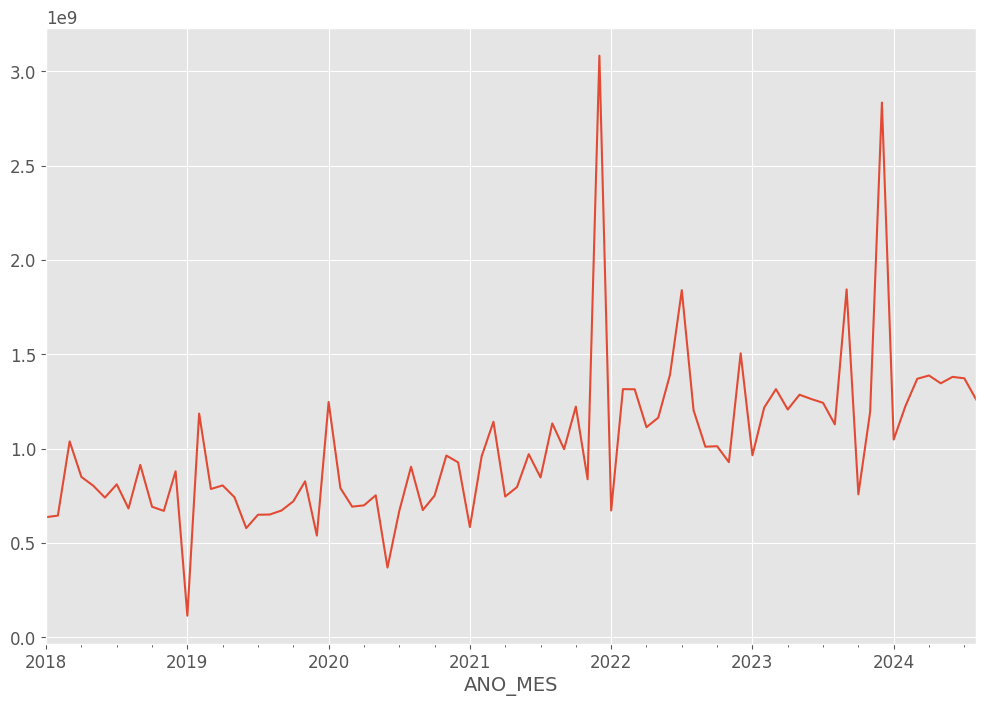

In [320]:
dados['VALOR_EMPENHADO'].plot(figsize=(12,8))

Grafico de densidade e distribuição

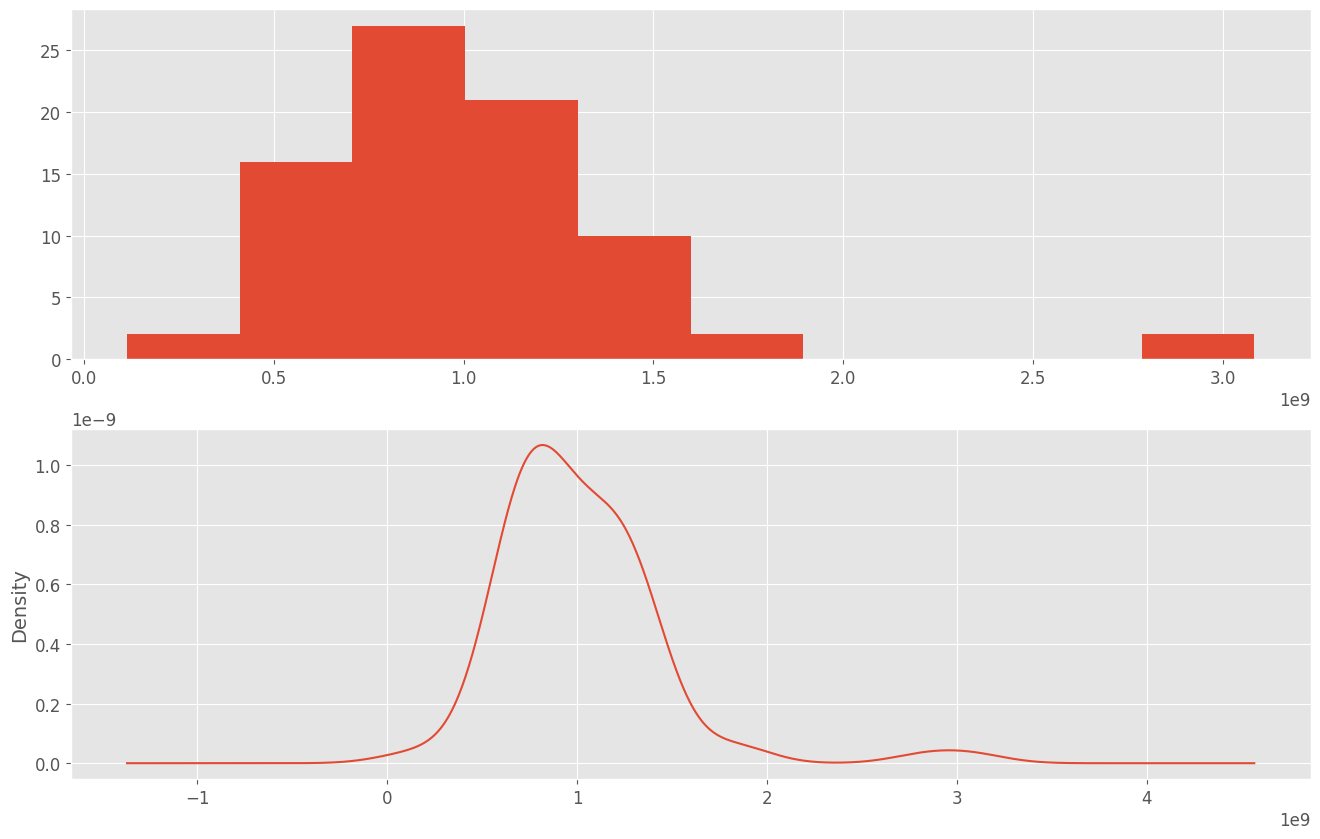

In [321]:
# Gráfico de Densidade
# Plot
plt.figure(1)

# subPlot 1
plt.subplot(211)
dados['VALOR_EMPENHADO'].hist()

# subPLot 2
plt.subplot(212)
dados['VALOR_EMPENHADO'].plot(kind='kde')
plt.show()

Grafico de Box-Plot

Text(0, 0.5, '\nValor Empenhado')

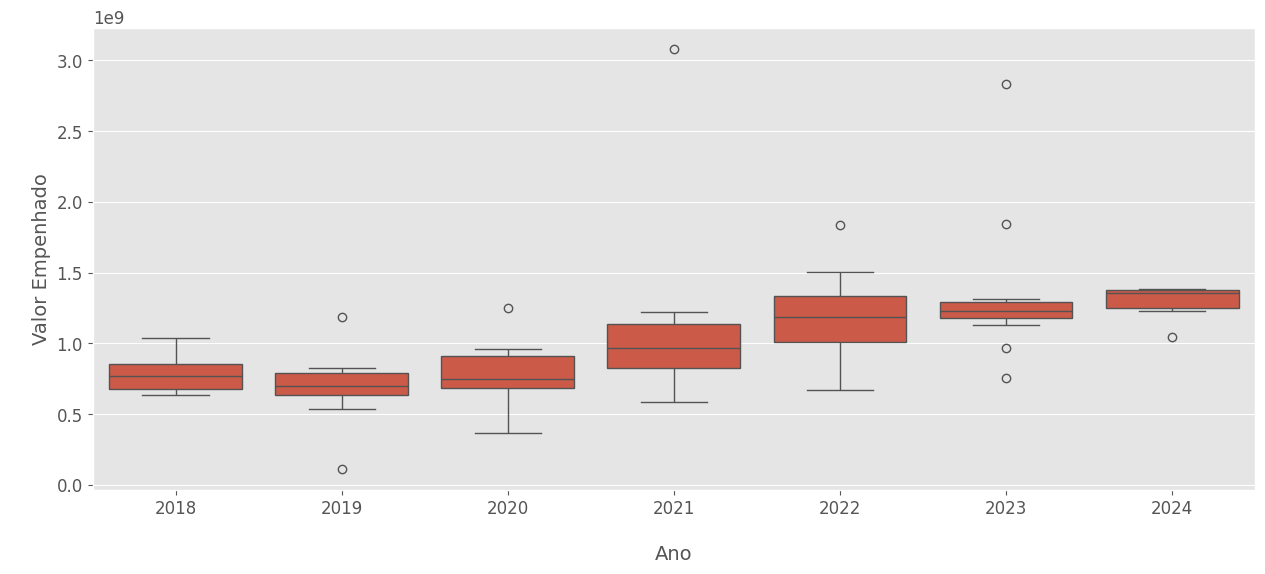

In [322]:
# Define a área de plotagem para os usbplots (os boxplots)
fig, ax = plt.subplots(figsize=(15,6))

# Define as variáveis
indice_ano = dados['VALOR_EMPENHADO'].index.year
valor = dados['VALOR_EMPENHADO']

# Cria um boxplot para cada ano usando o Seaborn
# Observe que estamos extraindo o ano (year) do índice da série
sns.boxplot(x=indice_ano, y=valor, ax=ax, data=dados)

plt.xlabel("\nAno")
plt.ylabel("\nValor Empenhado")

Decomposição Serial - Multiplicativa

In [323]:
# Decomposição da Série
decomposicao_multiplicativa = sm.tsa.seasonal_decompose(dados['VALOR_EMPENHADO'],
                                                        model='multiplicative',
                                                        extrapolate_trend='freq')

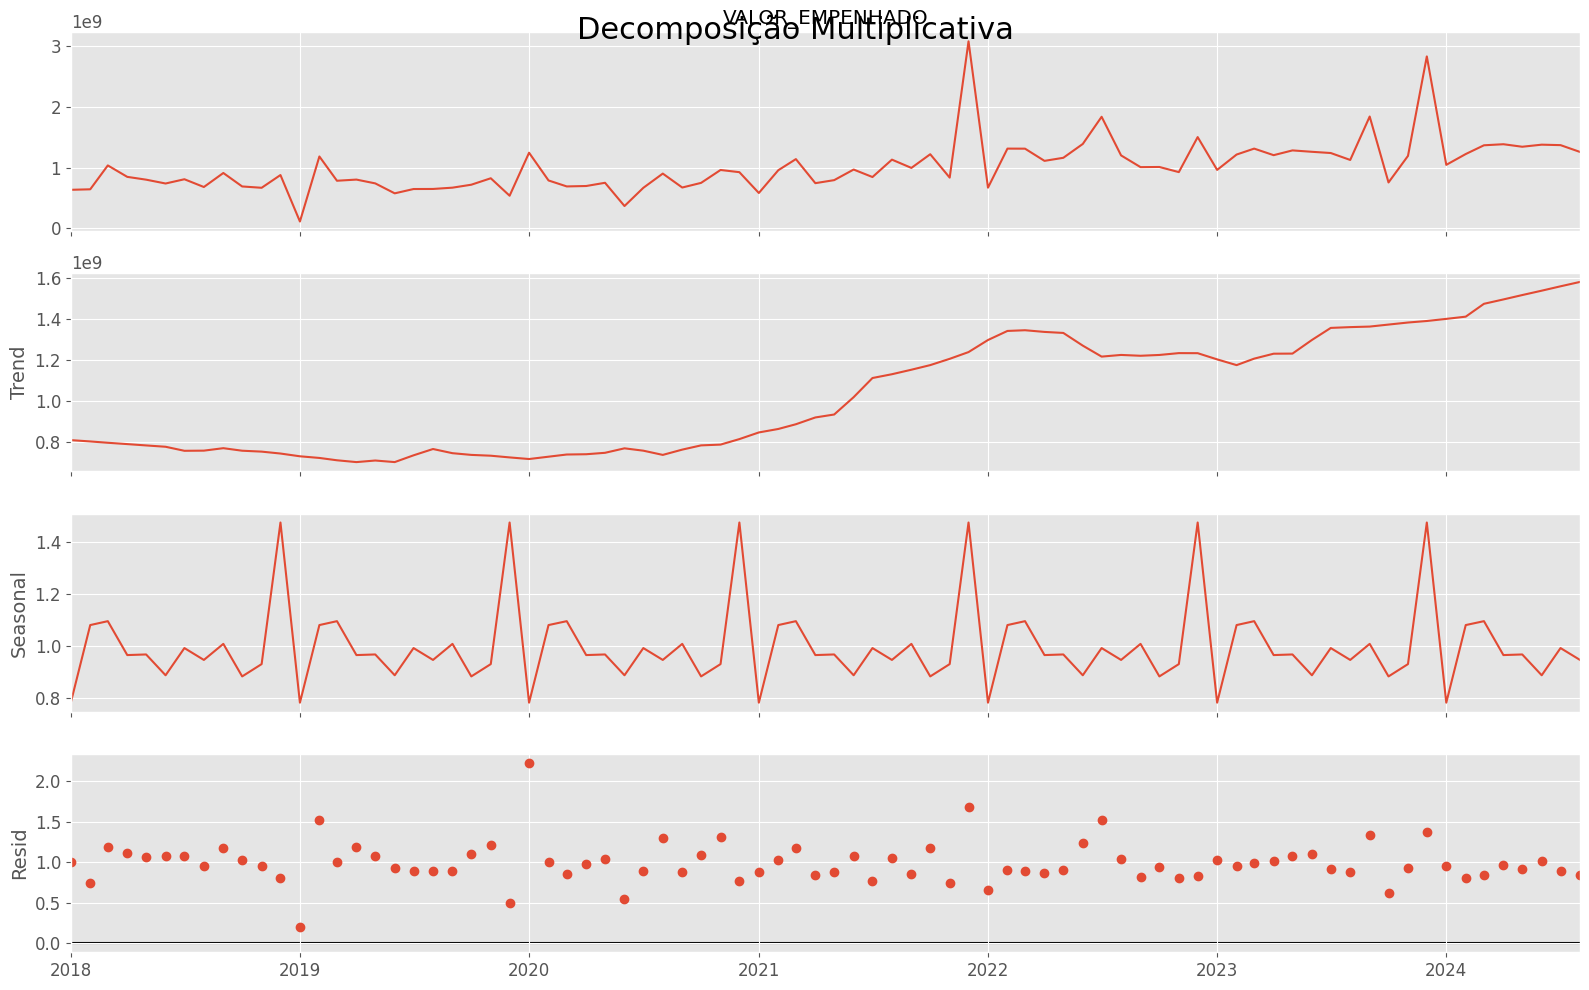

In [324]:
# Plot
plt.rcParams.update({'figure.figsize':(16,10)})
decomposicao_multiplicativa.plot().suptitle("Decomposição Multiplicativa", fontsize=22)
plt.show()

Decomposição Serial - Aditiva

In [325]:
# Decomposição da Série
decomposicao_aditive = sm.tsa.seasonal_decompose(dados['VALOR_EMPENHADO'],
                                                        model='aditive',
                                                        extrapolate_trend='freq')

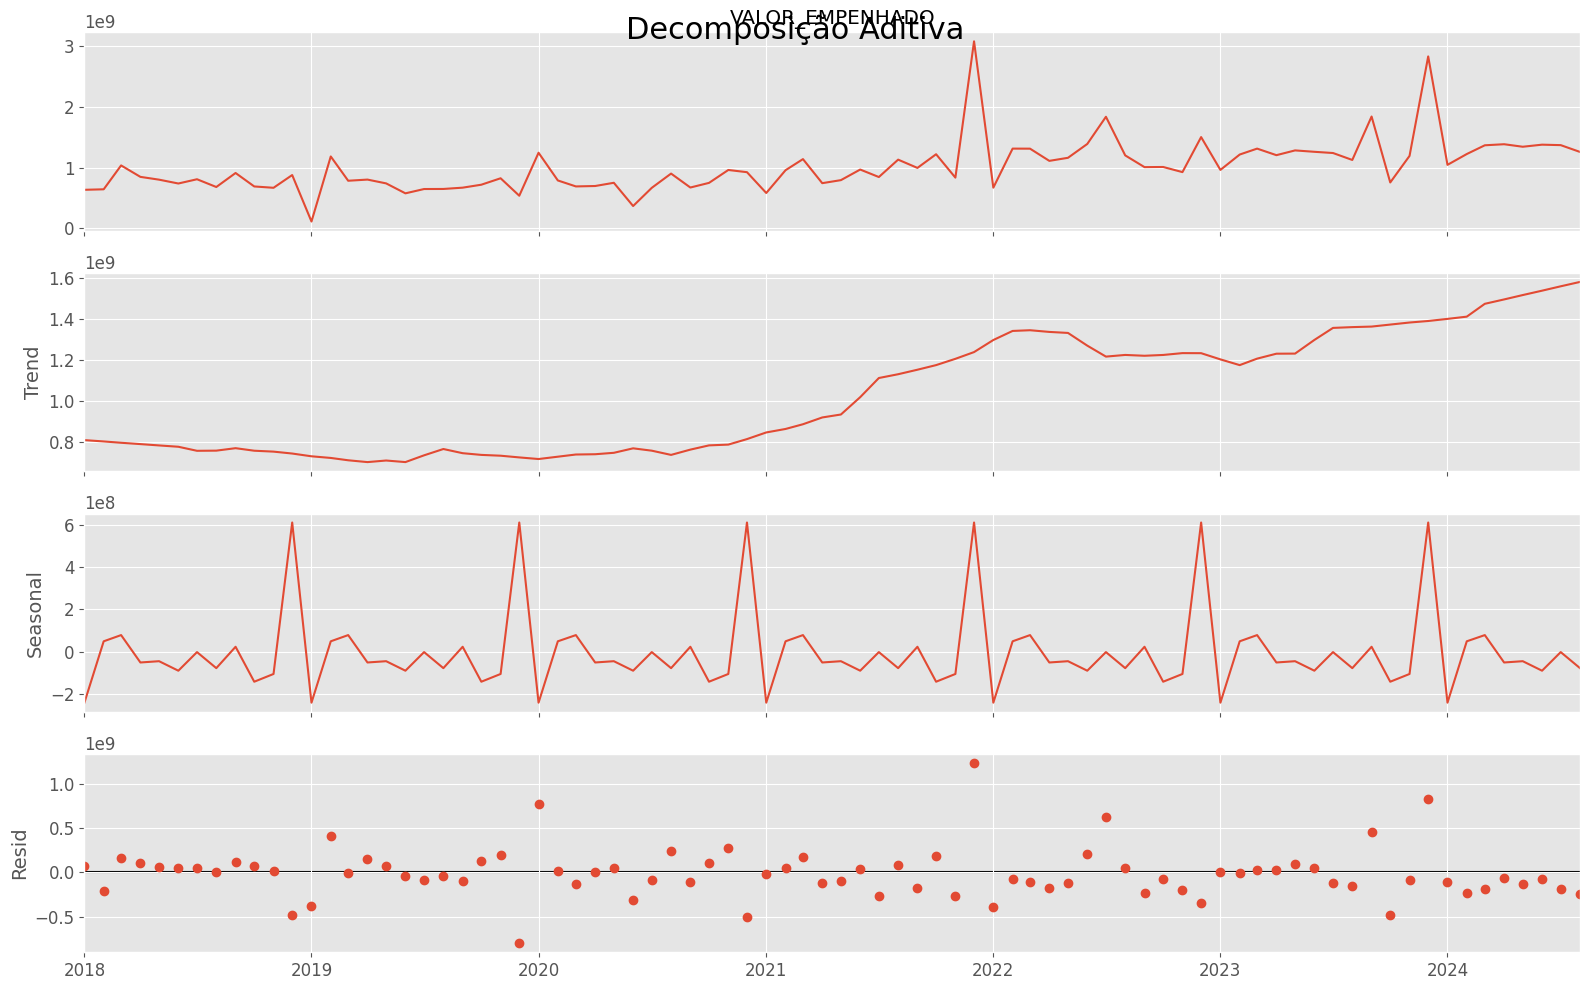

In [326]:
# Plot
plt.rcParams.update({'figure.figsize':(16,10)})
decomposicao_aditive.plot().suptitle("Decomposição Aditiva", fontsize=22)
plt.show()

Dados da Serie decomposta em um novo objeto:  
dados_serie_reconstruida

In [327]:
# Concatena o resultado da decomposição da série
dados_serie_reconstruida = pd.concat([decomposicao_multiplicativa.seasonal, 
                                      decomposicao_multiplicativa.trend, 
                                      decomposicao_multiplicativa.resid, 
                                      decomposicao_multiplicativa.observed], axis = 1)

In [328]:
# Define o nome das colunas
dados_serie_reconstruida.columns = ['Sazonalidade', 'Tendência', 'Resíduos', 'Valores_Observados']

___

# 3 - Estatísticas Móveis

In [329]:
# Determinando estatísticas móveis
rolmean = dados['VALOR_EMPENHADO'].rolling(window = 12).mean()
rolstd = dados['VALOR_EMPENHADO'].rolling(window = 12).std()

In [330]:
# Prepara os dados para o plot
x = dados['ANO_MES'].values
y = dados['VALOR_EMPENHADO'].values

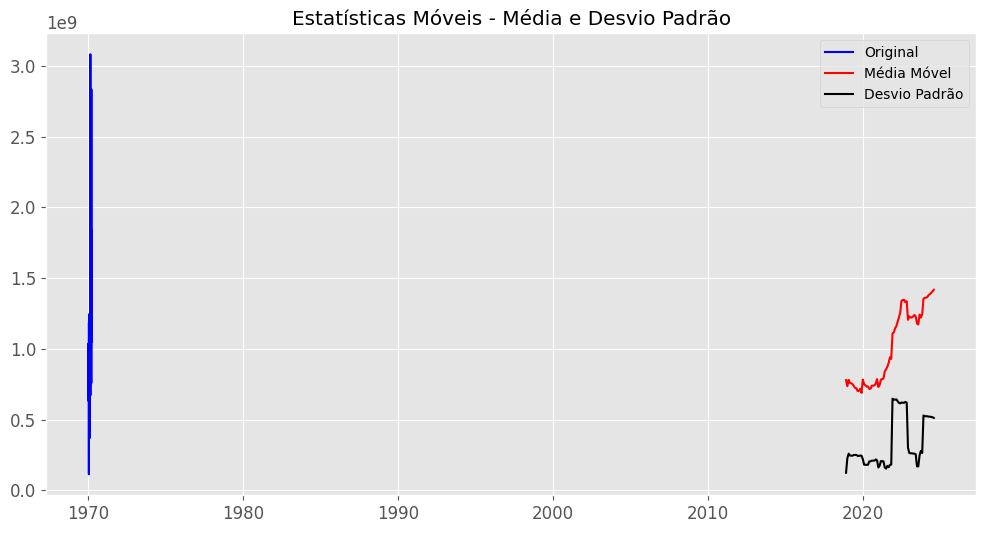

In [331]:
# Plot das estatísticas móveis
plt.figure(figsize = (12, 6))
orig = plt.plot(y, color = 'blue', label = 'Original')
mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
plt.legend(loc='best')
plt.title('Estatísticas Móveis - Média e Desvio Padrão')
plt.show()

Gŕafico de autocorrealção

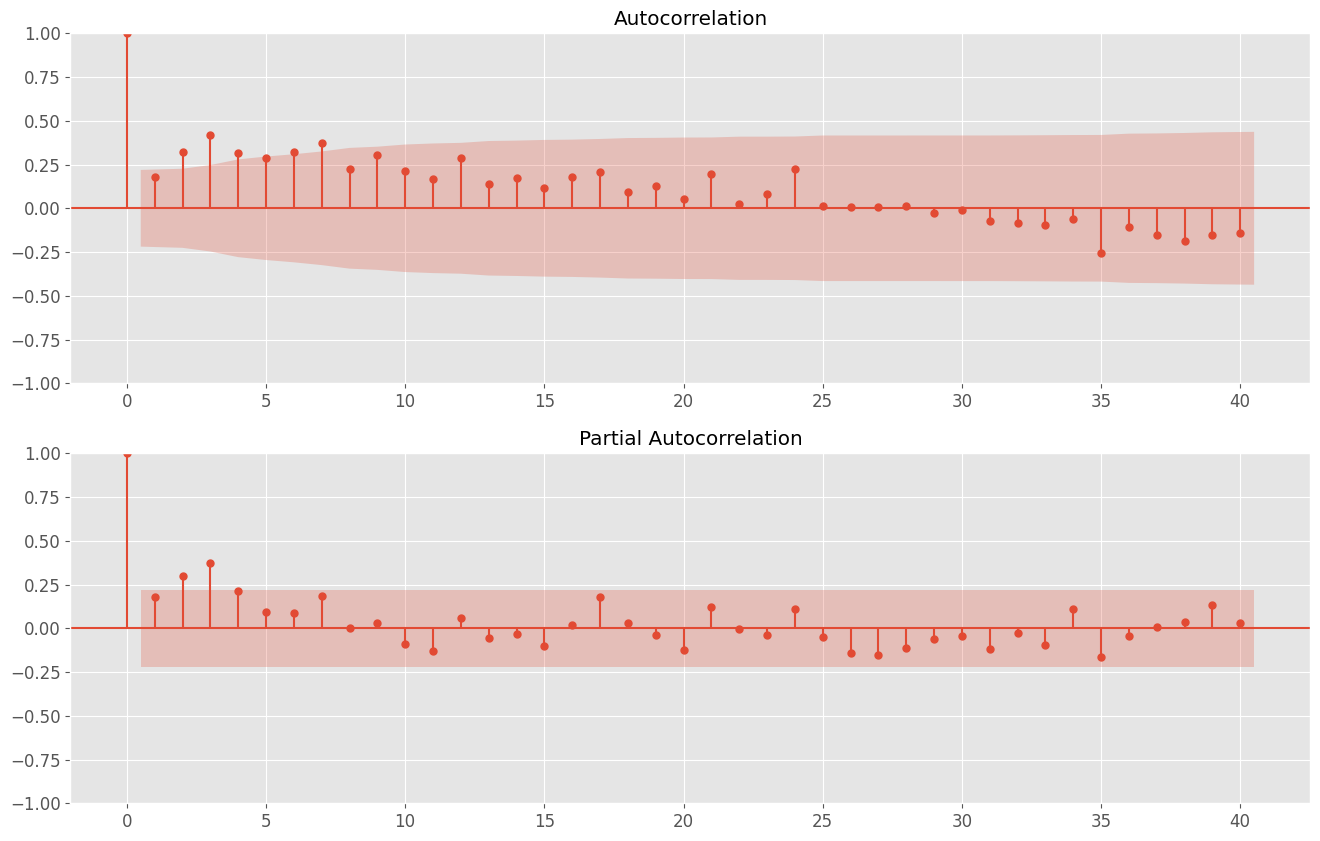

In [332]:
# Plots
plt.rcParams.update({'figure.figsize': (16,10)})

# Plot do gráfico ACF
plt.subplot(211)
plot_acf(dados['VALOR_EMPENHADO'], ax = plt.gca(), lags = 40)

# Plot do gráfico PACF
plt.subplot(212)
plot_pacf(dados['VALOR_EMPENHADO'], ax = plt.gca(), lags = 40, method = 'ywm')
plt.show()

# Teste de Sazionalidade
> Teste Dickey-Fuller Aumentado

# Automatização para testar estacionaridade
> Função para testar estacionaridade da série

*Nesse teste foi definido uma janela de 12 Meses!*

In [333]:
# Função para testar a estacionaridade
def dsa_testa_estacionaridade(serie, window = 12, title = 'Estatísticas Móveis e Teste Dickey-Fuller'):
    """
    Função para testar a estacionaridade de uma série temporal.
    
    Parâmetros:
    - serie: pandas.Series. Série temporal a ser testada.
    - window: int. Janela para cálculo das estatísticas móveis.
    - title: str. Título para os gráficos.
    """
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (14, 6))
    plt.plot(serie, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    plt.plot(rolstd, color = 'black', label = 'Desvio Padrão Móvel')
    plt.legend(loc = 'best')
    plt.title(title)
    plt.show(block = False)
    
    # Teste Dickey-Fuller
    print('\nResultado do Teste Dickey-Fuller:')
    dfteste = adfuller(serie, autolag = 'AIC')
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste', 
                                               'Valor-p', 
                                               'Número de Lags Consideradas', 
                                               'Número de Observações Usadas'])
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)' % key] = value
        
    print(dfsaida)
    
    # Conclusão baseada no valor-p
    if dfsaida['Valor-p'] > 0.05:
        print('\nConclusão:\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente não é estacionária.')
    else:
        print('\nConclusão:\nO valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente é estacionária.')

Função em execução.  
> LEMBRETE: Ao executar o teste, é removido 12 meses da amostra! (Configuavel na função "dsa_testa_estacionaridade)

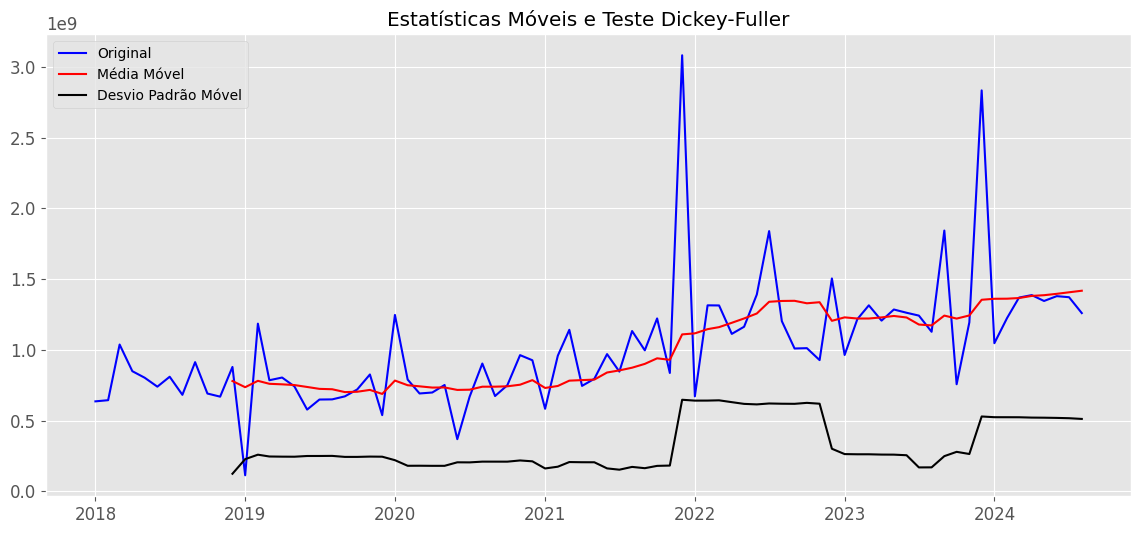


Resultado do Teste Dickey-Fuller:
Estatística do Teste            -1.712756
Valor-p                          0.424552
Número de Lags Consideradas      3.000000
Número de Observações Usadas    76.000000
Valor Crítico (1%)              -3.519481
Valor Crítico (5%)              -2.900395
Valor Crítico (10%)             -2.587498
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [334]:
# Executando nossa função
dsa_testa_estacionaridade(dados['VALOR_EMPENHADO'])

___

# 4 - Transformação em Estacionária

> Métodos para tornar a série estacionária:
- Log  
- Raiz Quadrada
- Box-Cox
- Suavização através da Média Móvel Simples (MMS)
- Suavização através da Média Móvel Ponderada Exponencial (MMPE)
- Diferenciação (existe vários tipos)

> Para esse notebook, foi aplicado apenas transformação de Log. 


Quando a média e o desvio padrão não são pŕoximos, provavelmente a série é não estacionária.

In [335]:
# Média da série
print('Média:', dados['VALOR_EMPENHADO'].mean())
# Desvio Padrão da Série
print(f'Desvio Padrão:', dados['VALOR_EMPENHADO'].std())

Média: 1018402016.1560001
Desvio Padrão: 439350721.64547384


### Transformação de LOG
> Aplicando a transformação de LOG

In [336]:
# Vamos aplicar uma transformação de log usando np.log() e gravamos o resultado em uma nova coluna do nosso dataset
dados['VALOR_EMPENHADO_log'] = np.log(dados['VALOR_EMPENHADO'])
dados.head()

,ANO_MES,VALOR_EMPENHADO,VALOR_EMPENHADO_log
ANO_MES,,,
2018-01-01,2018-01-01,6.361822e+08,20.270996
2018-02-01,2018-02-01,6.445037e+08,20.283991
2018-03-01,2018-03-01,1.037755e+09,20.760325
2018-04-01,2018-04-01,8.493252e+08,20.559953
2018-05-01,2018-05-01,8.033304e+08,20.504277


> Checando estacionáriadade após transformação

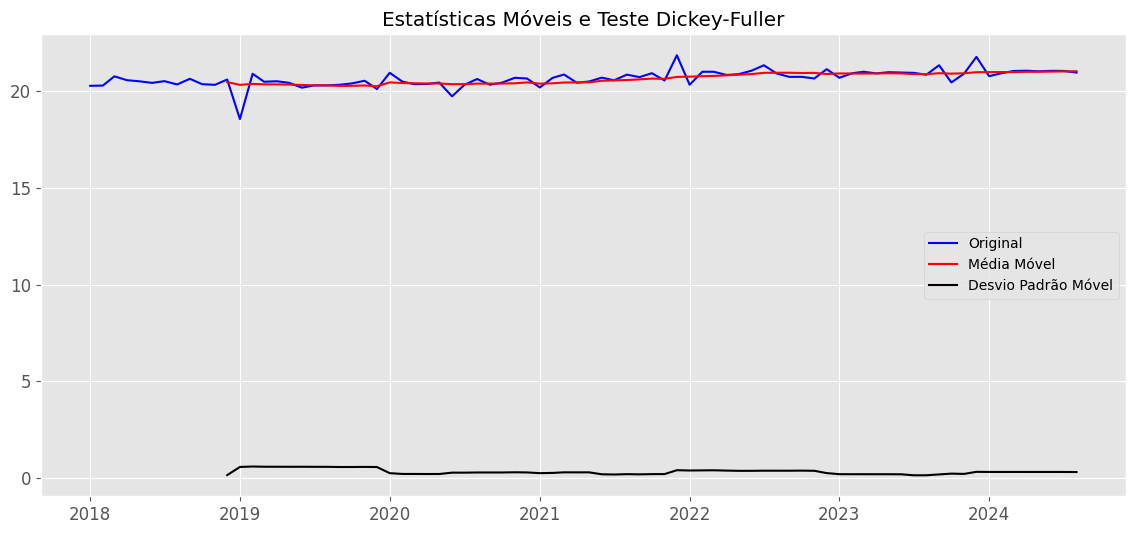


Resultado do Teste Dickey-Fuller:
Estatística do Teste            -0.678960
Valor-p                          0.852124
Número de Lags Consideradas      6.000000
Número de Observações Usadas    73.000000
Valor Crítico (1%)              -3.523284
Valor Crítico (5%)              -2.902031
Valor Crítico (10%)             -2.588371
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [337]:
# Testando Estacionaridade
dsa_testa_estacionaridade(dados['VALOR_EMPENHADO_log'])

Objetivo alcançado!

___

# 5 - Modelagem
> Existem vários modelos de previsão de série temporal:
- Forecasting - Método Naive (Método fraco)

Criação de um dataframe para prever valores futuros
> Esse dataframe contém 200 meses para frente, iniciando em 2024 - 09

Será usado futuramente

In [338]:
novos_meses = pd.date_range(start=dados.index[-1] + pd.DateOffset(months=1), periods=200, freq='MS')
df_novos_meses = pd.DataFrame({'VALOR_EMPENHADO': [0]*200}, index=novos_meses)
dados_previsao_futura = pd.concat([dados, df_novos_meses])
dados_previsao_futura = dados_previsao_futura[dados_previsao_futura['VALOR_EMPENHADO'] == 0]
dados_previsao_futura['data'] = dados_previsao_futura.index

Definição de Target / Valor alvo.
> Nesse caso, o valor alvo é 'VALOR_EMPENHADO', porém, será usado a sua transformação log realizada anteriormente

In [339]:
target = dados['VALOR_EMPENHADO_log']

#### Fatiando os dados, e escolhendo os dados treino e dados testes

Lembre-se do tamanho dos dados:

In [340]:
dados.shape

(80, 3)

In [341]:
df_treino = dados.iloc[0:50]
df_valid = dados.iloc[50:]

In [342]:
df_treino.head()

,ANO_MES,VALOR_EMPENHADO,VALOR_EMPENHADO_log
ANO_MES,,,
2018-01-01,2018-01-01,6.361822e+08,20.270996
2018-02-01,2018-02-01,6.445037e+08,20.283991
2018-03-01,2018-03-01,1.037755e+09,20.760325
2018-04-01,2018-04-01,8.493252e+08,20.559953
2018-05-01,2018-05-01,8.033304e+08,20.504277


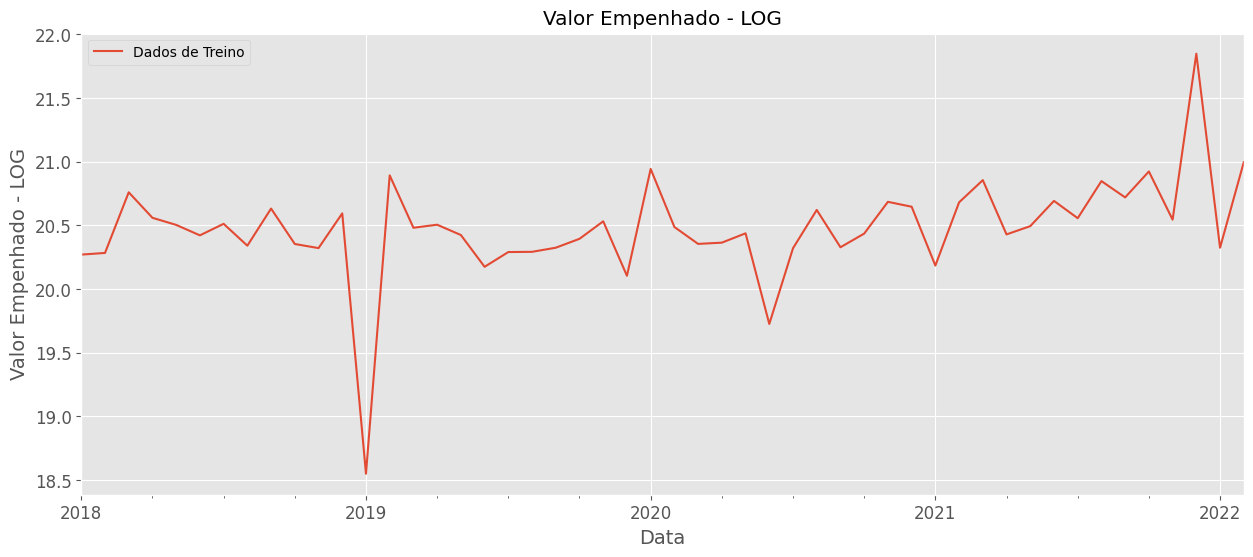

In [343]:
# Plot
figure(figsize = (15, 6))
df_treino['VALOR_EMPENHADO_log'].plot(title = 'Valor Empenhado - LOG', 
                               fontsize = 12, 
                               label = 'Dados de Treino') 
plt.xlabel("Data") 
plt.ylabel("Valor Empenhado - LOG") 
plt.legend(loc = 'best') 
plt.show()

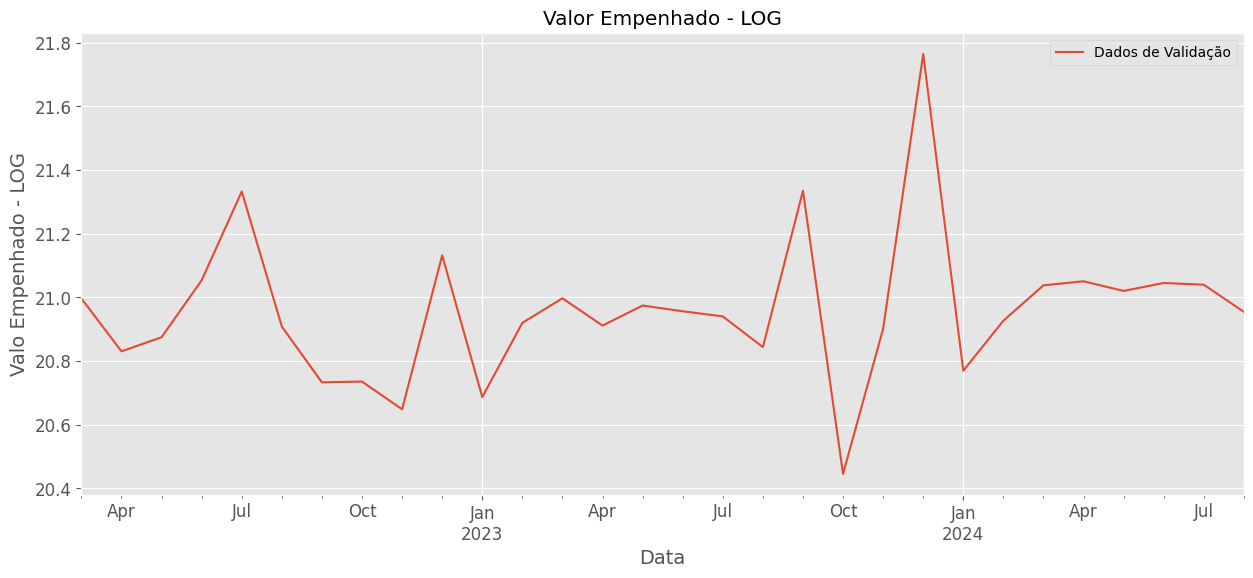

In [344]:
# Plot
figure(figsize = (15, 6))
df_valid['VALOR_EMPENHADO_log'].plot(title = 'Valor Empenhado - LOG', 
                              fontsize = 12, 
                              label = 'Dados de Validação') 
plt.xlabel("Data") 
plt.ylabel("Valo Empenhado - LOG") 
plt.legend(loc = 'best') 
plt.show()

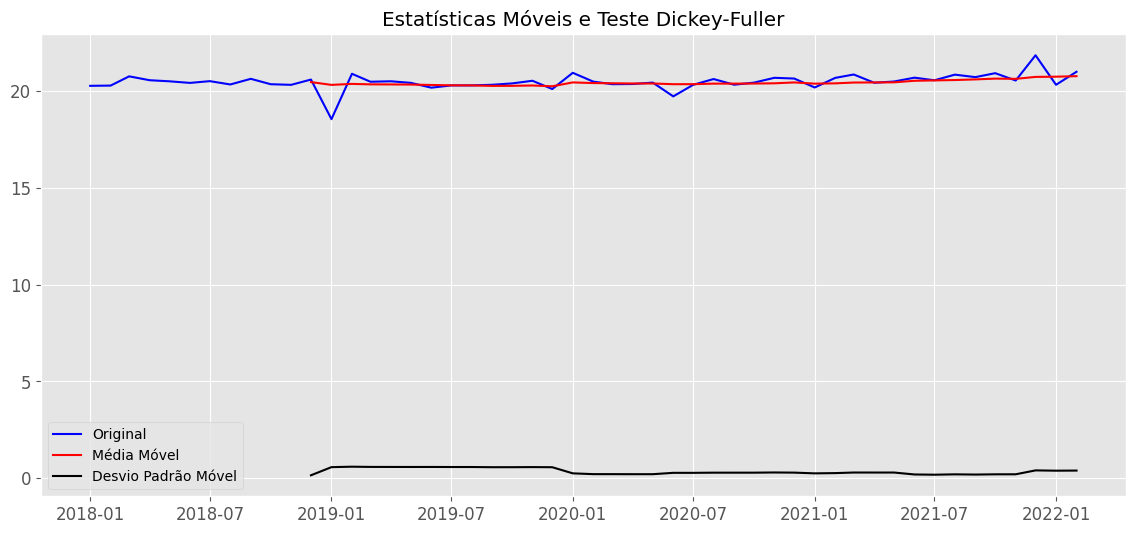


Resultado do Teste Dickey-Fuller:
Estatística do Teste           -7.581550e+00
Valor-p                         2.673637e-11
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    4.900000e+01
Valor Crítico (1%)             -3.571472e+00
Valor Crítico (5%)             -2.922629e+00
Valor Crítico (10%)            -2.599336e+00
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [345]:
dsa_testa_estacionaridade(df_treino['VALOR_EMPENHADO_log'])

# Forecasting

> Criando um Array com os valores da variavel Target em treino

In [346]:
# Criamos um array com os valores da variável target em treino
array_VALOR_EMPENHADO_log_treino = np.asarray(df_treino['VALOR_EMPENHADO_log'])

In [347]:
type(array_VALOR_EMPENHADO_log_treino)

numpy.ndarray

In [348]:
array_VALOR_EMPENHADO_log_treino.shape

(50,)

___

# Método Naive

In [349]:
# Cria uma cópia dos dados de validação para usar na comparação dos dados reais com as previsões
df_valid_cp = df_valid.copy()

In [350]:
len(array_VALOR_EMPENHADO_log_treino)

50

In [351]:
# Previsão. Sim, isso é o Método Naive!
df_valid_cp['previsao_naive'] = array_VALOR_EMPENHADO_log_treino[len(array_VALOR_EMPENHADO_log_treino) - 1] 

In [352]:
df_valid_cp[['VALOR_EMPENHADO_log', 'previsao_naive']].head()

,VALOR_EMPENHADO_log,previsao_naive
ANO_MES,,
2022-03-01,20.996341,20.996981
2022-04-01,20.830318,20.996981
2022-05-01,20.874752,20.996981
2022-06-01,21.053608,20.996981
2022-07-01,21.332645,20.996981


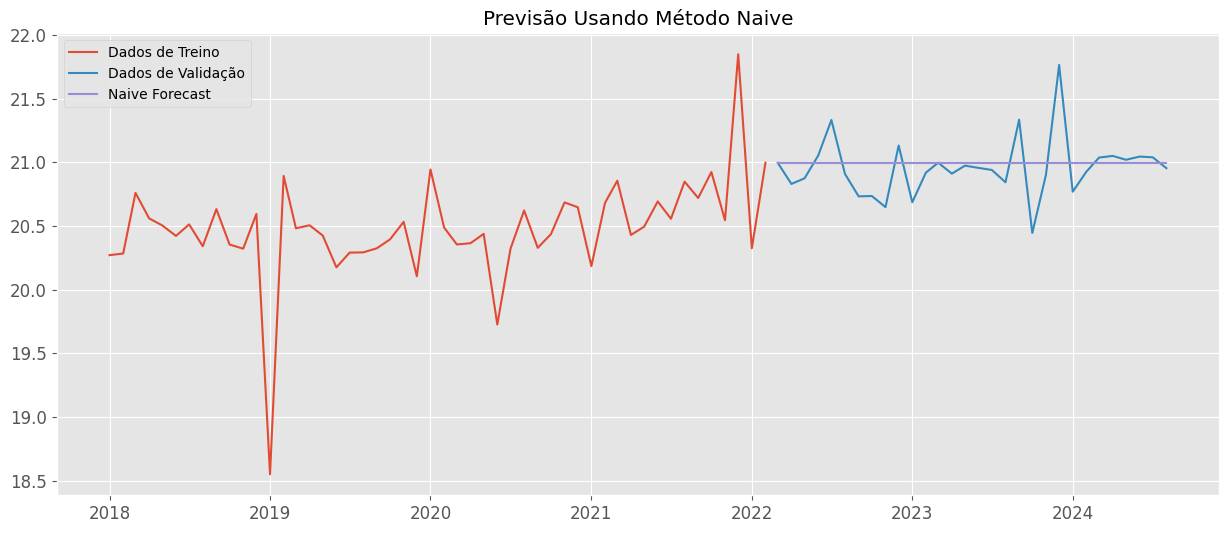

In [353]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Método Naive") 
plt.plot(df_treino.index, df_treino['VALOR_EMPENHADO_log'], label = 'Dados de Treino') 
plt.plot(df_valid.index, df_valid['VALOR_EMPENHADO_log'], label = 'Dados de Validação') 
plt.plot(df_valid_cp.index, df_valid_cp['previsao_naive'], label = 'Naive Forecast') 
plt.legend(loc = 'best') 
plt.show()

In [354]:
# Define valor real e valor previsto
y_true = df_valid_cp['VALOR_EMPENHADO_log']
y_pred = df_valid_cp['previsao_naive']

In [355]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.2358209381555979


RMSE é a taxa de erro e quanto menor, melhor!

# Exponenial Smoothing

### Ideal quando a série não apresenta tendência e/ou sazionalidade

Exponential Smoothing é uma técnica de modelagem de séries temporais que utiliza uma média móvel ponderada para prever valores futuros de uma série temporal. Cada ponto de dado é atribuído com um peso exponencial decrescente, com os pontos mais recentes recebendo mais peso e os pontos mais antigos recebendo menos peso. O resultado é uma previsão suavizada que leva em consideração tanto a tendência geral quanto a sazonalidade da série temporal.

In [356]:
# Versão 1 do modelo - Simple Exponential Smoothing 
modelo_v1 = SimpleExpSmoothing(array_VALOR_EMPENHADO_log_treino).fit(smoothing_level = 0.2, optimized = True)

In [357]:
# Previsões com o Modelo
df_valid['previsoes_v1'] = modelo_v1.forecast(len(df_valid)) 

In [358]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid[['VALOR_EMPENHADO_log', 'previsoes_v1']].head()

,VALOR_EMPENHADO_log,previsoes_v1
ANO_MES,,
2022-03-01,20.996341,20.827327
2022-04-01,20.830318,20.827327
2022-05-01,20.874752,20.827327
2022-06-01,21.053608,20.827327
2022-07-01,21.332645,20.827327


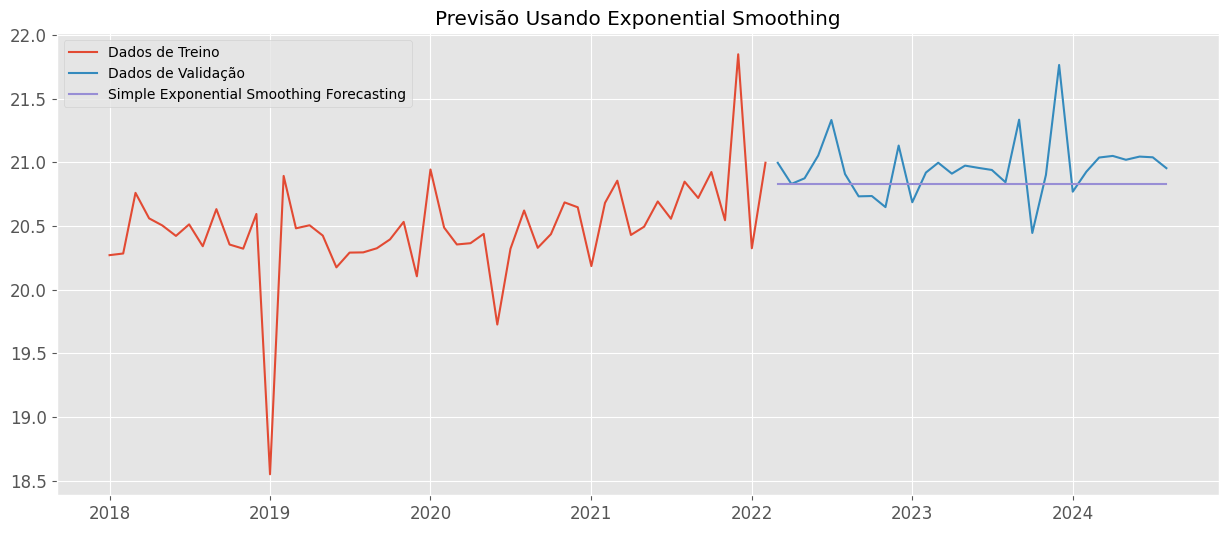

In [359]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(df_treino['VALOR_EMPENHADO_log'], label = 'Dados de Treino')
plt.plot(df_valid['VALOR_EMPENHADO_log'], label = 'Dados de Validação')
plt.plot(df_valid['previsoes_v1'], label = 'Simple Exponential Smoothing Forecasting') 
plt.legend(loc = 'best') 
plt.show()

In [360]:
# Define valor real e valor previsto
y_true = df_valid['VALOR_EMPENHADO_log']
y_pred = df_valid.previsoes_v1

In [361]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.2672618206612543


___

# Double Exponential Smoothing -> Ideal com tendência
> Ao usar o hiperparâmetro trend, definimos o método Double Exponential Smoothing.
# Triple Exponential Smoothing -> Ideal com Sazionalidade
> Ao usar o hiperparâmetro seasonal, definimos o método Triple Exponential Smoothing.


In [362]:
# Versão 2 do modelo - Double Exponential Smoothing 
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

# Observe que estamos usando a função ExponentialSmoothing().
# Ao usar o hiperparâmetro trend, definimos o método Double Exponential Smoothing.
# Ao usar o hiperparâmetro seasonal, definimos o método Triple Exponential Smoothing.

# Vamos usar o Double. Como não temos sazonalidade na série, não faz muito sentido usar o Triple.
# Escolhi a série aditiva
modelo_v2 = ExponentialSmoothing(np.asarray(df_treino['VALOR_EMPENHADO_log']), 
                                 trend = 'additive').fit(smoothing_level = 0.9, 
                                                         optimized = True) 

In [363]:
# Previsões com o Modelo
df_valid.loc[:,'previsoes_v2'] = modelo_v2.forecast(len(df_valid))

In [364]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid[['VALOR_EMPENHADO_log', 'previsoes_v1', 'previsoes_v2']].head()

,VALOR_EMPENHADO_log,previsoes_v1,previsoes_v2
ANO_MES,,,
2022-03-01,20.996341,20.827327,20.958889
2022-04-01,20.830318,20.827327,20.972510
2022-05-01,20.874752,20.827327,20.986130
2022-06-01,21.053608,20.827327,20.999751
2022-07-01,21.332645,20.827327,21.013371


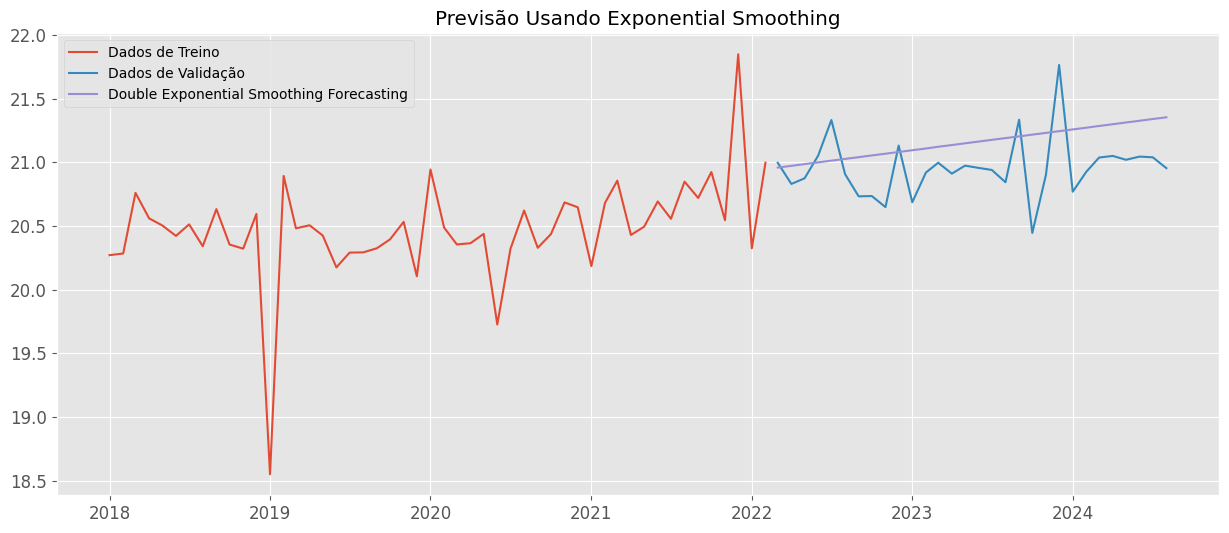

In [365]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(df_treino['VALOR_EMPENHADO_log'], label = 'Dados de Treino')
plt.plot(df_valid['VALOR_EMPENHADO_log'], label = 'Dados de Validação')
plt.plot(df_valid['previsoes_v2'], label = 'Double Exponential Smoothing Forecasting') 
plt.legend(loc = 'best') 
plt.show()

In [366]:
# Define valor real e valor previsto
y_true = df_valid['VALOR_EMPENHADO_log']
y_pred = df_valid.previsoes_v2

In [367]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.3128769417793556


#### Resultados acima insatisfatórios, pode indicar que métodos de Exponential Smoothing não sejam adequados para à série selecionada.

Ganhos muitos baixos, o erro do modelo foi pouco diminuido

___

### Ainda com modelos lineares, porém com outra familia
1 - Naive  
2 - Suavização Exponensial (simples, duplo e triple)  
3 - Modelos lineares da familia ARIMA


**Podemos converter o problema de série temporal, em um problema de machine learning**

# Familia Linear

Em Estatística e Econometria, e em particular na análise de séries temporais, um modelo de média móvel integrada auto-regressiva (ARIMA) é uma generalização de um modelo de média móvel auto-regressiva (ARMA). 

Ambos os modelos são ajustados a dados de séries temporais para melhor entender os dados ou para prever pontos futuros na série (previsão). Os modelos ARIMA são aplicados em alguns casos em que os dados mostram evidências de não estacionariedade, onde uma etapa inicial de diferenciação (correspondente à parte "integrada" do modelo) pode ser aplicada uma ou mais vezes para eliminar a não estacionariedade. 

A parte AR do ARIMA indica que a variável de interesse em evolução é regredida com seus próprios valores defasados (isto é, anteriores). A parte MA indica que o erro de regressão é na verdade uma combinação linear de termos de erro cujos valores ocorreram contemporaneamente e em vários momentos no passado. O I (para "integrado") indica que os valores dos dados foram substituídos pela diferença entre seus valores e os valores anteriores (e esse processo de diferenciação pode ter sido executado mais de uma vez). O objetivo de cada um desses recursos é fazer com que o modelo ajuste os dados da melhor maneira possível.

Modelos ARIMA não sazonais são geralmente designados ARIMA(p, d, q), em que os parâmetros p, d e q são números inteiros não negativos, p é a ordem (número de intervalos de tempo) do modelo autoregressivo, d é o grau de diferenciação (o número de vezes que os dados tiveram valores passados subtraídos) e q é a ordem do modelo de média móvel. 

Modelos ARIMA sazonais são geralmente designados ARIMA (p, d, q) (P, D, Q) m, em que m refere-se ao número de períodos em cada season e os maiúsculos P, D, Q referem-se ao autorregressivo, diferenciado, e termos da média móvel da parte sazonal do modelo ARIMA.

Quando dois dos três termos são zeros, o modelo pode ser referido com base no parâmetro diferente de zero, eliminando "AR", "I" ou "MA" da sigla que descreve o modelo. Por exemplo, ARIMA (1,0,0) é AR (1), ARIMA (0,1,0) é I (1) e ARIMA (0,0,1) é MA (1).

In [368]:
df_treino.shape

(50, 3)

In [369]:
df_valid.shape

(30, 5)

In [370]:
# AR, MA, ARMA, ARIMA, ARIMAX, SARIMA, SARIMAX

# Modelos AR e modelos MA, normalmente são muitos simples, só usa se a séria temporal for muio básica.
# Para série compelxas, usa o ARIMA.
# Para série complexas com sazionalidade usa o SARIMA.

In [371]:
df_treino.head()

,ANO_MES,VALOR_EMPENHADO,VALOR_EMPENHADO_log
ANO_MES,,,
2018-01-01,2018-01-01,6.361822e+08,20.270996
2018-02-01,2018-02-01,6.445037e+08,20.283991
2018-03-01,2018-03-01,1.037755e+09,20.760325
2018-04-01,2018-04-01,8.493252e+08,20.559953
2018-05-01,2018-05-01,8.033304e+08,20.504277


In [372]:
# Cria o Modelo ARIMA

# Definimos:

# p = 2
# d = 1
# q = 0

# Modelo
modelo_AR = ARIMA(df_treino['VALOR_EMPENHADO_log'], order = (2, 1, 0), freq = 'MS')

In [373]:
# Treinamento
modelo_v3 = modelo_AR.fit()  

In [374]:
# Dados Reais e Previsões (em treino)
dados_reais = df_treino['VALOR_EMPENHADO_log']
previsoes_v3 = modelo_v3.fittedvalues

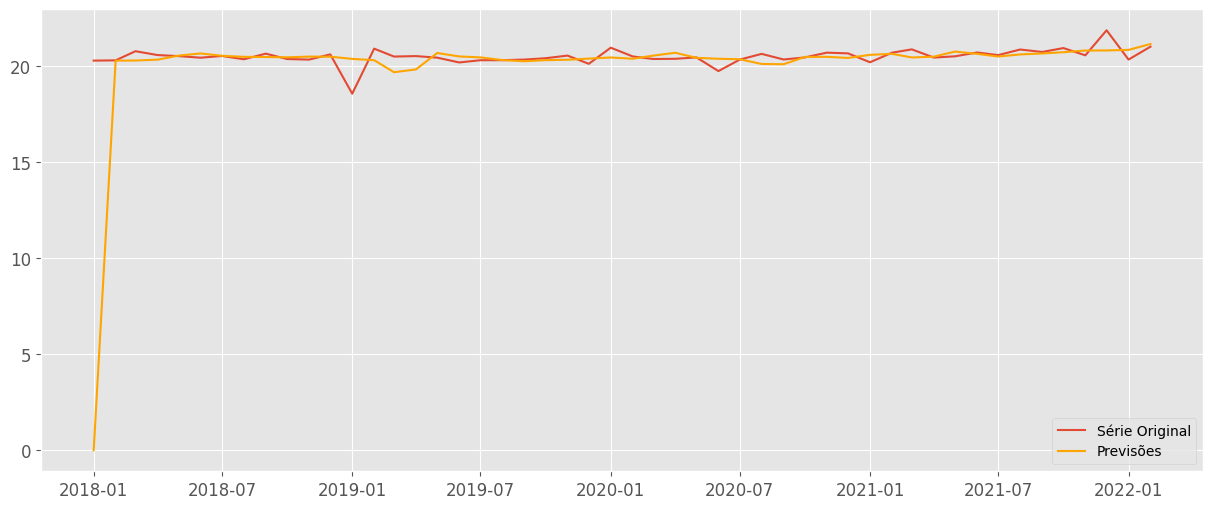

In [375]:
# Plot
figure(figsize = (15, 6))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes_v3, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

Verificar sigma2, quanto menor "melhor"

In [376]:
# Sumário do Modelo 
modelo_v3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     VALOR_EMPENHADO_log   No. Observations:                   50
Model:                  ARIMA(2, 1, 0)   Log Likelihood                 -27.655
Date:                 Thu, 19 Sep 2024   AIC                             61.310
Time:                         13:04:40   BIC                             66.986
Sample:                     01-01-2018   HQIC                            63.464
                          - 02-01-2022                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9117      0.102     -8.968      0.000      -1.111      -0.712
ar.L2         -0.4453      0.105     -4.251      0.000      -0.651      -0.240
sigma2         0.1776      0.019      9.401      0.000       0.141       0.215
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):                86.04
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -1.24
Prob(H) (two-sided):                  0.07   Kurtosis:                         9.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Aqui está uma interpretação dos resultados:

Modelo: ARIMA(2,1,0) indica que o modelo é um processo autorregressivo de segunda ordem (AR(2)) com uma diferenciação (I(1)) e sem parte de médias móveis (MA(0)).

Parâmetros AR:

- ar.L1: O coeficiente do primeiro termo autorregressivo é -0.3419, o que significa que há uma relação negativa entre o valor atual da série e o valor imediatamente anterior.
- ar.L2: O coeficiente do segundo termo autorregressivo é -0.0695, indicando uma relação negativa mais fraca com o segundo valor anterior.
- Variância do erro (sigma2): O valor de 0.1610 indica a variância dos erros do modelo. Quanto menor esse valor, melhor o ajuste do modelo aos dados.

Testes Estatísticos:

- Ljung-Box (Q): O teste Ljung-Box verifica a autocorrelação residual. Um valor de p (Prob(Q)) próximo de 1, como 0.95 aqui, sugere que não há evidências significativas de autocorrelação residual, indicando um bom ajuste do modelo.
- Jarque-Bera (JB): Este teste verifica a normalidade dos resíduos. Um valor de p (Prob(JB)) próximo de 0, como aqui, indica que os resíduos não são normalmente distribuídos. Isso pode ser uma preocupação e pode valer a pena investigar mais.
- Heteroskedasticity (H): Este teste verifica a homocedasticidade dos resíduos. Um valor de p (Prob(H)) próximo de 0 indica que há evidências de heterocedasticidade, o que significa que a variância dos resíduos não é constante ao longo do tempo.

Medidas de ajuste:

- AIC (Akaike Information Criterion): 16244.711. Um valor menor indica um melhor ajuste do modelo, mas é usado principalmente para comparar modelos.
- BIC (Bayesian Information Criterion): 16267.763. Assim como o AIC, um valor menor indica um melhor ajuste e é usado para comparações entre modelos.
- HQIC (Hannan-Quinn Information Criterion): 16252.334. Mais uma medida para comparar modelos, com um valor menor indicando um melhor ajuste.

O modelo ARIMA(2,1,0) parece se ajustar bem aos dados em termos de autocorrelação, mas há preocupações com a normalidade e a homocedasticidade dos resíduos. Isso pode afetar as previsões do modelo e a interpretação dos intervalos de confiança. Pode ser útil investigar transformações dos dados, adicionar variáveis exógenas ou considerar modelos alternativos para melhorar o ajuste.

In [377]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes_v3 = modelo_v3.forecast(len(df_valid['VALOR_EMPENHADO_log']), alpha = 0.05) 

In [378]:
df_previsoes_v3.shape

(30,)

In [379]:
df_previsoes_v3.head()

2022-03-01    21.062920
2022-04-01    20.703586
2022-05-01    21.001816
2022-06-01    20.889937
2022-07-01    20.859136
Freq: MS, Name: predicted_mean, dtype: float64

In [380]:
# Criamos a série para o gráfico
fc_series = pd.Series(df_previsoes_v3, index = df_valid.index)

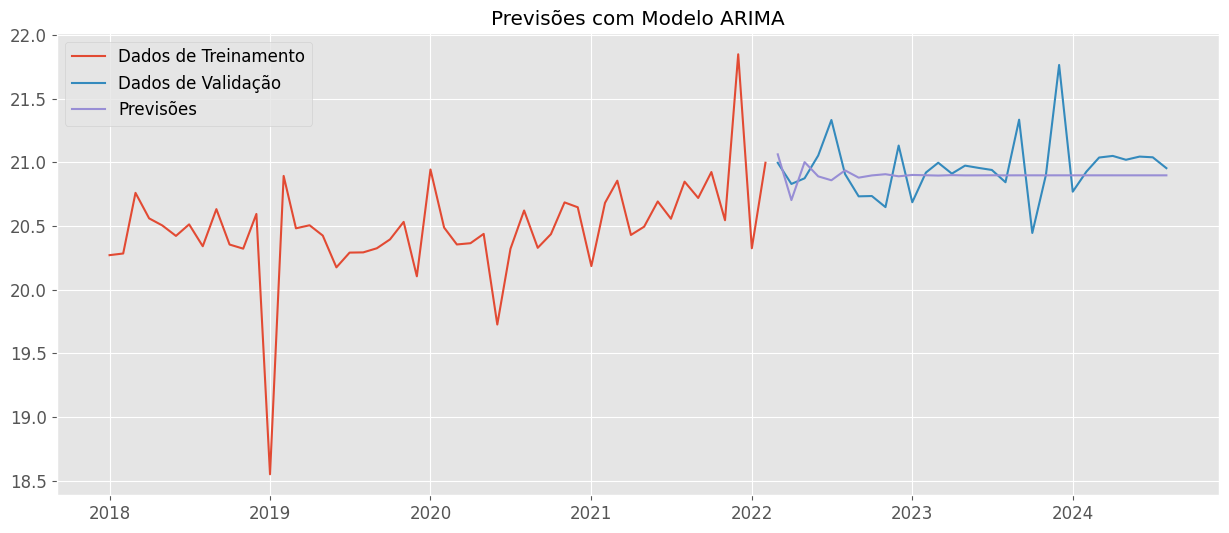

In [381]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino['VALOR_EMPENHADO_log'], label = 'Dados de Treinamento')
plt.plot(df_valid['VALOR_EMPENHADO_log'], label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [382]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [383]:
df_valid.head()

,ANO_MES,VALOR_EMPENHADO,VALOR_EMPENHADO_log,previsoes_v1,previsoes_v2
ANO_MES,,,,,
2022-03-01,2022-03-01,1.313999e+09,20.996341,20.827327,20.958889
2022-04-01,2022-04-01,1.112992e+09,20.830318,20.827327,20.972510
2022-05-01,2022-05-01,1.163563e+09,20.874752,20.827327,20.986130
2022-06-01,2022-06-01,1.391444e+09,21.053608,20.827327,20.999751
2022-07-01,2022-07-01,1.839289e+09,21.332645,20.827327,21.013371


In [384]:
# Define valor real e valor previsto
y_true = df_valid['VALOR_EMPENHADO_log']
y_pred = fc_series

In [385]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.24491806102539468


___

# Moledo - HW!

In [386]:
dados

,ANO_MES,VALOR_EMPENHADO,VALOR_EMPENHADO_log
ANO_MES,,,
2018-01-01,2018-01-01,6.361822e+08,20.270996
2018-02-01,2018-02-01,6.445037e+08,20.283991
2018-03-01,2018-03-01,1.037755e+09,20.760325
2018-04-01,2018-04-01,8.493252e+08,20.559953
2018-05-01,2018-05-01,8.033304e+08,20.504277
...,...,...,...
2024-04-01,2024-04-01,1.387101e+09,21.050482
2024-05-01,2024-05-01,1.345654e+09,21.020146
2024-06-01,2024-06-01,1.379791e+09,21.045198


Definindo freq

In [387]:
dados.freq = 'MS'

Definindo o valor de Alpha e definindo m (périodo de tempo)

In [388]:
m = 12
alpha = 1 / (2 * m)

<Axes: title={'center': 'Holt-Winters Exponential Smoothing'}, xlabel='ANO_MES'>

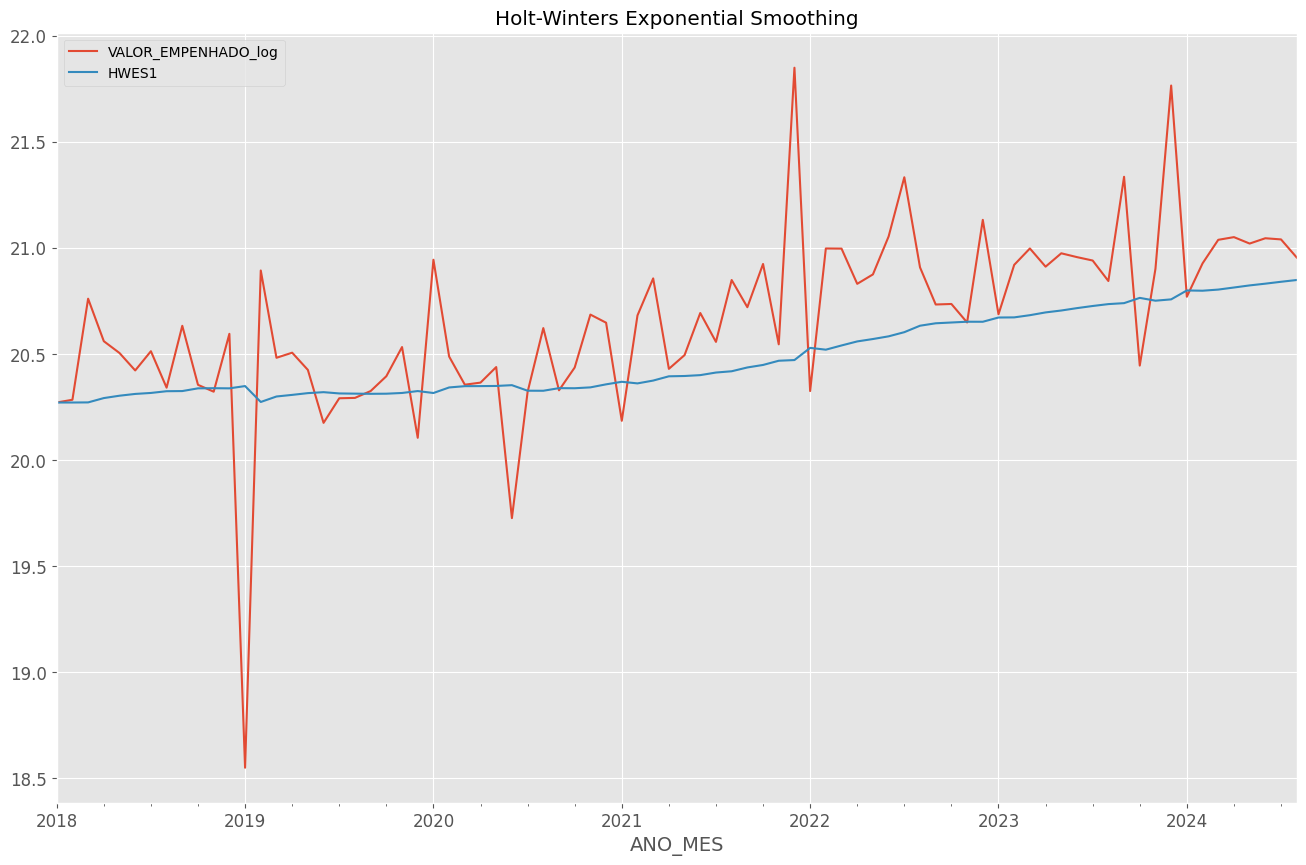

In [389]:
dados['HWES1'] = SimpleExpSmoothing(dados['VALOR_EMPENHADO_log']).fit(smoothing_level=alpha, optimized=False, use_brute=True).fittedvalues
dados[['VALOR_EMPENHADO_log', 'HWES1']].plot(title='Holt-Winters Exponential Smoothing')

HWES duplo
Então, ajustaríamos os dados no Double ES, tanto na tendência aditiva quanto na multiplicativa,


<Axes: title={'center': 'Holt-Winters Double Exponential Smoothing'}, xlabel='ANO_MES'>

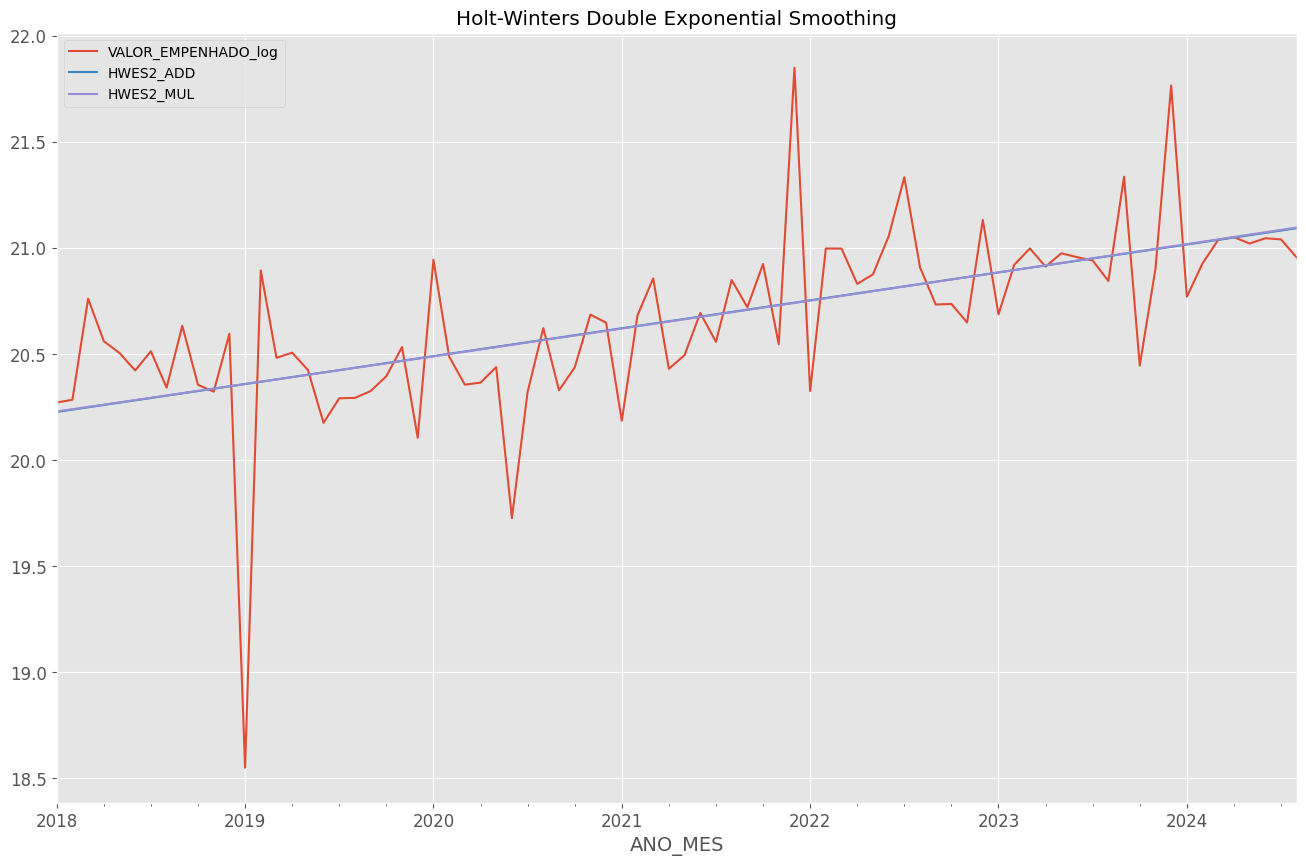

In [390]:

dados['HWES2_ADD'] = ExponentialSmoothing(dados['VALOR_EMPENHADO_log'], trend='add').fit().fittedvalues
dados['HWES2_MUL'] = ExponentialSmoothing(dados['VALOR_EMPENHADO_log'], trend='mul').fit().fittedvalues
dados[['VALOR_EMPENHADO_log', 'HWES2_ADD', 'HWES2_MUL']].plot(title='Holt-Winters Double Exponential Smoothing')

Triplo HWES3

<Axes: title={'center': 'Holt-Winters Triple Exponential Smoothing'}, xlabel='ANO_MES'>

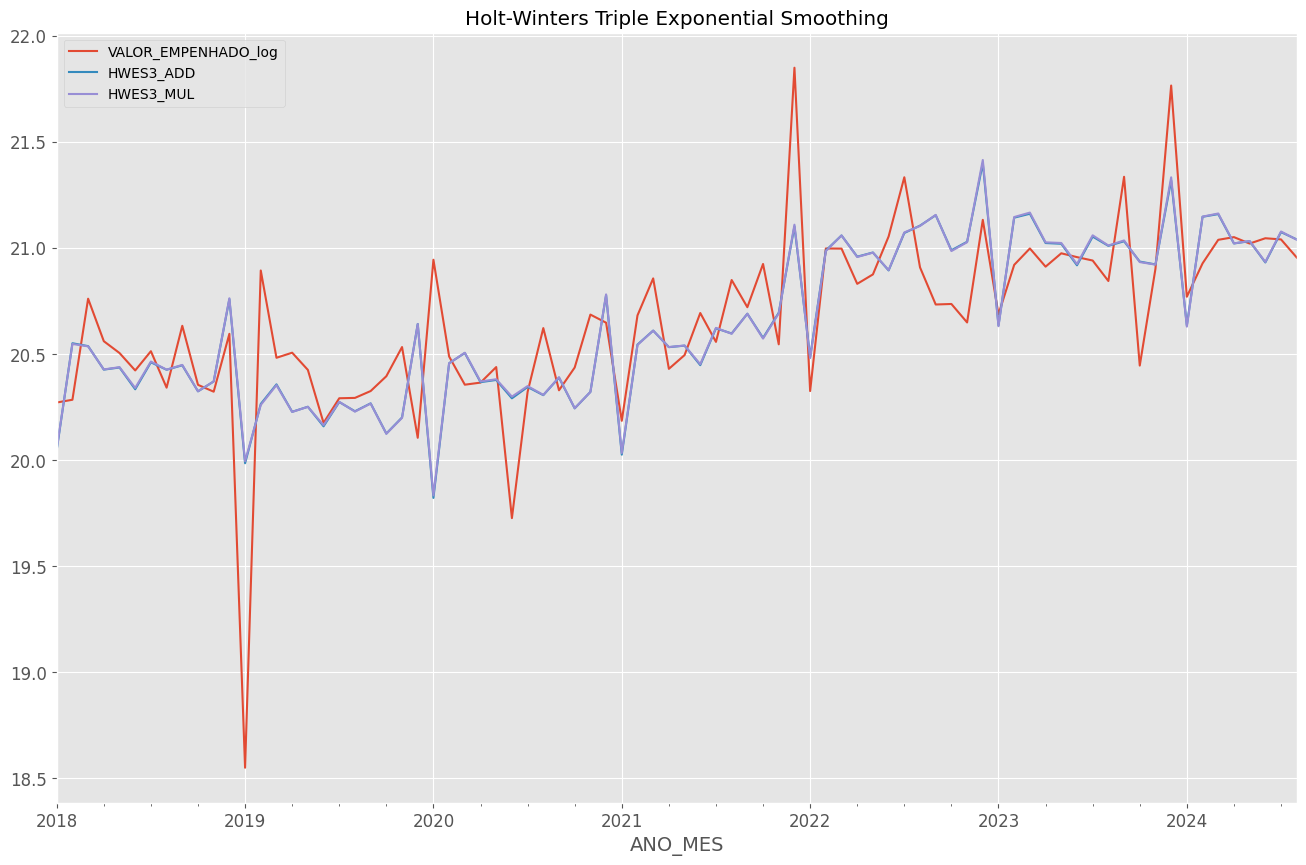

In [391]:
# Triplo HWES3_ADD
dados['HWES3_ADD'] = ExponentialSmoothing(dados['VALOR_EMPENHADO_log'], trend='add', seasonal='add', seasonal_periods=12).fit().fittedvalues
dados['HWES3_MUL'] = ExponentialSmoothing(dados['VALOR_EMPENHADO_log'], trend='mul', seasonal='mul', seasonal_periods=12).fit().fittedvalues
dados[['VALOR_EMPENHADO_log', 'HWES3_ADD', 'HWES3_MUL']].plot(title='Holt-Winters Triple Exponential Smoothing')

### Previsão

Text(0.5, 1.0, 'Treino, teste, previsão Holt Winters')

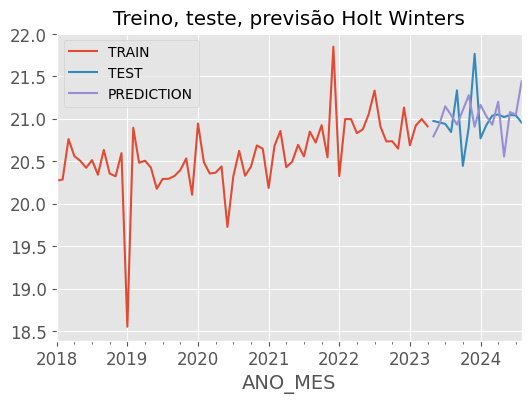

In [392]:
# Seprando treino e teste
train = dados.iloc[:len(dados)-16]
test = dados.iloc[len(dados)-16:]

# Ajustando o modelo
fitted_model = ExponentialSmoothing(train['VALOR_EMPENHADO_log'], trend='mul', seasonal='mul', seasonal_periods=16).fit()
test_predictions = fitted_model.forecast(16)

train['VALOR_EMPENHADO_log'].plot(legend=True, label='TRAIN', figsize=(6, 4))
test['VALOR_EMPENHADO_log'].plot(legend=True, label='TEST', figsize=(6, 4))
test_predictions.plot(legend=True, label='PREDICTION', figsize=(6, 4))

plt.title('Treino, teste, previsão Holt Winters')

In [393]:
np.exp(test_predictions)

2023-05-01    1.071649e+09
2023-06-01    1.234389e+09
2023-07-01    1.528165e+09
2023-08-01    1.378685e+09
2023-09-01    1.231428e+09
2023-10-01    1.460903e+09
2023-11-01    1.740077e+09
2023-12-01    1.200106e+09
2024-01-01    1.553801e+09
2024-02-01    1.358068e+09
2024-03-01    1.229524e+09
2024-04-01    1.612847e+09
2024-05-01    8.459466e+08
2024-06-01    1.426496e+09
2024-07-01    1.384934e+09
2024-08-01    2.055807e+09
Freq: MS, dtype: float64

In [394]:
test.head()

,ANO_MES,VALOR_EMPENHADO,VALOR_EMPENHADO_log,HWES1,HWES2_ADD,HWES2_MUL,HWES3_ADD,HWES3_MUL
ANO_MES,,,,,,,,
2023-05-01,2023-05-01,1.285294e+09,20.974253,20.704624,20.927978,20.928462,21.019183,21.022913
2023-06-01,2023-06-01,1.262349e+09,20.956240,20.715858,20.938940,20.939583,20.917704,20.923057
2023-07-01,2023-07-01,1.242229e+09,20.940173,20.725874,20.949901,20.950710,21.052943,21.059050
2023-08-01,2023-08-01,1.127934e+09,20.843653,20.734803,20.960863,20.961842,21.009343,21.010976
2023-09-01,2023-09-01,1.843372e+09,21.334862,20.739339,20.971825,20.972981,21.030974,21.034760


In [395]:
# A valiação do modelo para cada modelo em coluna

for coluna in test.columns[2:]:
    print(f'{coluna}:')
    print('MAE:', mean_absolute_error(test[coluna], test_predictions))
    print('MSE:', mean_squared_error(test[coluna], test_predictions))
    print('RMSE:', np.sqrt(mean_squared_error(test[coluna], test_predictions)))
    print('MAPE:', mean_absolute_percentage_error(test[coluna], test_predictions))
    print('\n')



VALOR_EMPENHADO_log:
MAE: 0.2912466300501473
MSE: 0.1404900750574174
RMSE: 0.37482005690386605
MAPE: 0.013839605895781776


HWES1:
MAE: 0.2919964226420593
MSE: 0.10395535390521746
RMSE: 0.32242108166994515
MAPE: 0.014049705883980048


HWES2_ADD:
MAE: 0.1419373492797107
MSE: 0.03784978745988295
RMSE: 0.1945502183496152
MAPE: 0.0067516283879605265


HWES2_MUL:
MAE: 0.14160028858663942
MSE: 0.03776391002759477
RMSE: 0.19432938539396138
MAPE: 0.006734930596642874


HWES3_ADD:
MAE: 0.21970562535074234
MSE: 0.07419861764702404
RMSE: 0.2723942320369946
MAPE: 0.010464410499021335


HWES3_MUL:
MAE: 0.22117769429653222
MSE: 0.07564060663031077
RMSE: 0.2750283742276618
MAPE: 0.010533340978155468




___

VALOR_EMPENHADO_log:
MAE: 0.2386113804900838
MSE: 0.13208280925629473
RMSE: 0.36343198711216207
MAPE: 0.013981399411988187


HWES1:
MAE: 0.29729132589338003
MSE: 0.1114764491220055
RMSE: 0.3338808906211997
MAPE: 0.017691949821757112


HWES2_ADD:
MAE: 0.2181913097863204
MSE: 0.09743322110245889
RMSE: 0.3121429497881682
MAPE: 0.012852227525841066


HWES2_MUL:
MAE: 0.2178338279070131
MSE: 0.09763792836972068
RMSE: 0.31247068401647005
MAPE: 0.012829856193876917


HWES3_ADD:
MAE: 0.2137103536056566
MSE: 0.11222844903650167
RMSE: 0.3350051477761225
MAPE: 0.01267724707501405


HWES3_MUL:
MAE: 0.21483123901133117
MSE: 0.11346336430017265
RMSE: 0.3368432340127565
MAPE: 0.01274611846712382




# SARIMAX
Otimização de hiperparâmetros  
Facilidade com sazionalidade

In [396]:
# Cria o modelo
modelo_SARIMAX = SARIMAX(df_treino['VALOR_EMPENHADO_log'], trend = 'n', order = (6,1,0), seasonal_order = (0,1,1,12))

In [397]:
# Treinamento do modelo
modelo_v4 = modelo_SARIMAX.fit(disp = True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.57893D-01    |proj g|=  3.52562D-01

At iterate    1    f=  6.11971D-01    |proj g|=  4.16359D-01

At iterate    2    f=  5.63673D-01    |proj g|=  2.49751D-01

At iterate    3    f=  5.42490D-01    |proj g|=  1.00190D-01

At iterate    4    f=  5.34943D-01    |proj g|=  9.10517D-02

At iterate    5    f=  5.29061D-01    |proj g|=  5.53393D-02

At iterate    6    f=  5.25334D-01    |proj g|=  2.62375D-02

At iterate    7    f=  5.24421D-01    |proj g|=  2.00090D-02

At iterate    8    f=  5.23207D-01    |proj g|=  3.49498D-02

At iterate    9    f=  5.22092D-01    |proj g|=  5.15922D-02

At iterate   10    f=  5.21414D-01    |proj g|=  9.06708D-03

At iterate   11    f=  5.21037D-01    |proj g|=  8.38055D-03

At iterate   12    f=  5.20923D-01    |proj g|=  7.77501D-03

At iterate   13    f=  5.2

 This problem is unconstrained.



At iterate   18    f=  5.20355D-01    |proj g|=  6.74275D-03

At iterate   19    f=  5.20333D-01    |proj g|=  6.26322D-03

At iterate   20    f=  5.20330D-01    |proj g|=  5.38290D-03

At iterate   21    f=  5.20328D-01    |proj g|=  1.89783D-03

At iterate   22    f=  5.20326D-01    |proj g|=  2.08561D-03

At iterate   23    f=  5.20324D-01    |proj g|=  2.39406D-03

At iterate   24    f=  5.20324D-01    |proj g|=  1.94165D-03

At iterate   25    f=  5.20322D-01    |proj g|=  5.86682D-04

At iterate   26    f=  5.20322D-01    |proj g|=  2.42015D-04

At iterate   27    f=  5.20322D-01    |proj g|=  8.16903D-04

At iterate   28    f=  5.20322D-01    |proj g|=  3.72234D-04

At iterate   29    f=  5.20321D-01    |proj g|=  7.45254D-04

At iterate   30    f=  5.20321D-01    |proj g|=  4.02819D-04

At iterate   31    f=  5.20321D-01    |proj g|=  3.56896D-04

At iterate   32    f=  5.20321D-01    |proj g|=  6.66512D-05

At iterate   33    f=  5.20321D-01    |proj g|=  2.78548D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


In [398]:
# Dados Reais e Previsões (em treino)
dados_reais = df_treino['VALOR_EMPENHADO_log']
previsoes_v4 = modelo_v4.fittedvalues

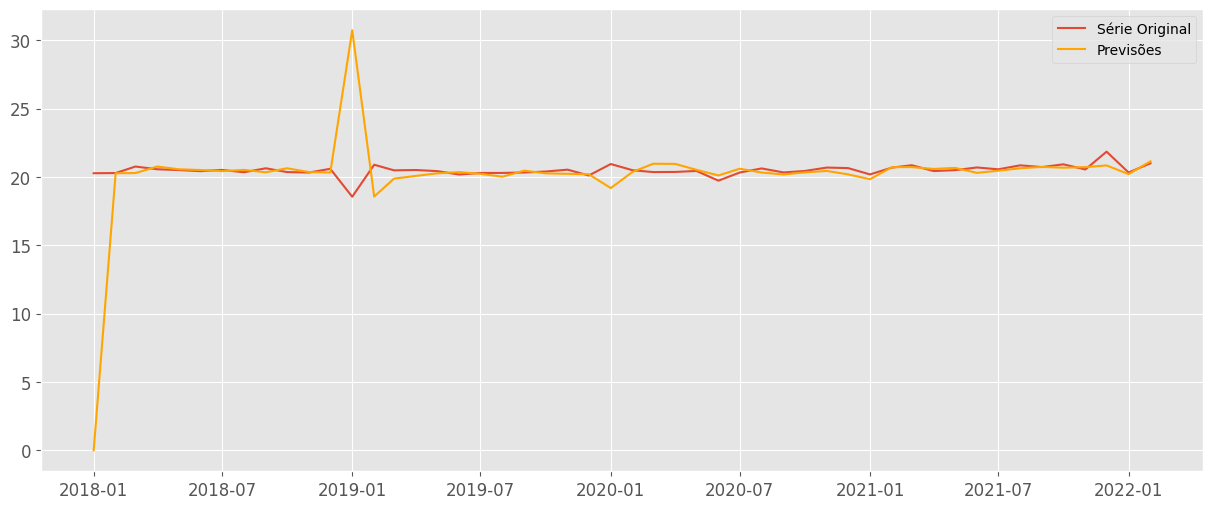

In [399]:
# Plot
figure(figsize = (15, 6))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes_v4, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [400]:
# Sumário do Modelo 
modelo_v4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                  VALOR_EMPENHADO_log   No. Observations:                   50
Model:             SARIMAX(6, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -26.016
Date:                              Thu, 19 Sep 2024   AIC                             68.032
Time:                                      13:04:42   BIC                             80.919
Sample:                                  01-01-2018   HQIC                            72.575
                                       - 02-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0800      0.263     -4.100      0.000      -1.596      -0.564
ar.L2         -0.7812      0.394     -1.983      0.047      -1.553      -0.009
ar.L3         -0.4531      0.440     -1.029      0.303      -1.316       0.410
ar.L4         -0.3527      0.476     -0.741      0.459      -1.285       0.580
ar.L5         -0.3503      0.445     -0.787      0.431      -1.223       0.522
ar.L6         -0.1576      0.309     -0.511      0.609      -0.762       0.447
ma.S.L12      -0.9821     11.154     -0.088      0.930     -22.843      20.879
sigma2         0.1487      1.662      0.089      0.929      -3.109       3.406
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                27.20
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             1.44
Prob(H) (two-sided):                  0.06   Kurtosis:                         6.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Este modelo SARIMAX (Seasonal AutoRegressive Integrated Moving-Average with eXogenous variables) é um modelo de série temporal que inclui componentes sazonais. O modelo especificado é SARIMAX(6, 1, 0)x(0, 1, [1], 12), o que significa:

Parte não sazonal (ARIMA):

- AR(6): Processo autorregressivo de ordem 6.
- I(1): Diferenciação de primeira ordem.
- MA(0): Sem parte de médias móveis.

Parte sazonal:

- SAR(0): Sem componente autorregressivo sazonal.
- SI(1): Diferenciação sazonal de ordem 1.
- SMA(1): Média móvel sazonal de ordem 1.
- Período sazonal: 12 (indicando sazonalidade anual, presumivelmente mensal).

Aqui está uma interpretação dos resultados:

- Parâmetros AR: Os coeficientes dos termos autorregressivos (ar.L1 a ar.L6) mostram a relação entre o valor atual da série e seus valores anteriores. Por exemplo, o coeficiente ar.L1 é -0.4178, indicando uma relação negativa forte com o valor anterior.

- Parâmetro MA sazonal (ma.S.L12): O coeficiente de -0.9965 é muito próximo de -1, indicando uma forte relação negativa com o erro do termo sazonal anterior.

- Variância do erro (sigma2): O valor de 0.1464 indica a variância dos erros do modelo.

Testes Estatísticos:

- Ljung-Box (Q): Um valor de p (Prob(Q)) próximo de 1, como 0.99 aqui, sugere que não há evidências significativas de autocorrelação residual.
- Jarque-Bera (JB): Um valor de p (Prob(JB)) próximo de 0 indica que os resíduos não são normalmente distribuídos.
- Heteroskedasticity (H): Um valor de p (Prob(H)) próximo de 0 indica evidências de heterocedasticidade.

Medidas de ajuste:

- AIC (Akaike Information Criterion): 14776.188. Usado para comparar modelos, com um valor menor indicando um melhor ajuste.
- BIC (Bayesian Information Criterion): 14837.652. Semelhante ao AIC, um valor menor indica um melhor ajuste.
- HQIC (Hannan-Quinn Information Criterion): 14796.514. Outra medida para comparar modelos.

O modelo SARIMAX(6,1,0)x(0,1,[1],12) parece se ajustar bem aos dados em termos de autocorrelação, mas há preocupações com a normalidade e a homocedasticidade dos resíduos. A forte componente de média móvel sazonal indica uma relação significativa com os erros sazonais anteriores. Seria útil investigar a transformação dos dados ou a inclusão de variáveis exógenas para melhorar a normalidade dos resíduos e a homocedasticidade.

In [401]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes_v4 = modelo_v4.forecast(len(df_valid['VALOR_EMPENHADO_log']), alpha = 0.05) 

In [402]:
df_previsoes_v4.shape

(30,)

In [403]:
# Cria a série para o gráfico
fc_series = pd.Series(df_previsoes_v4, index = df_valid.index)

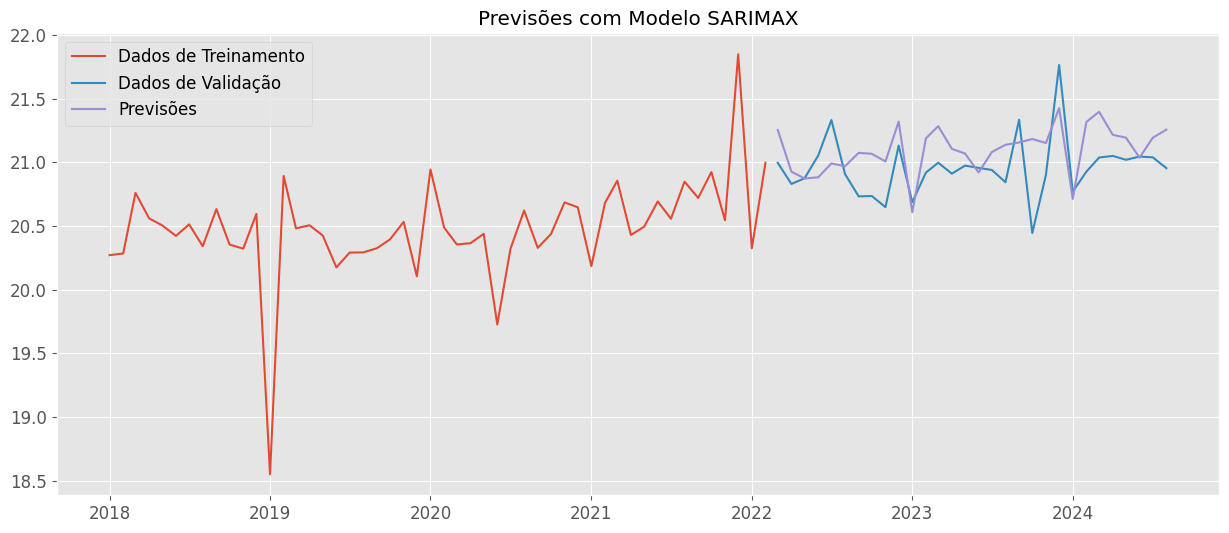

In [404]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino['VALOR_EMPENHADO_log'], label = 'Dados de Treinamento')
plt.plot(df_valid['VALOR_EMPENHADO_log'], label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.title('Previsões com Modelo SARIMAX')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [405]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [406]:
# Define valor real e valor previsto
y_true = df_valid['VALOR_EMPENHADO_log']
y_pred = fc_series

In [407]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.26730576310881626


___

### Previsões com a versão SARIMAX

Previsões para o melhor modelo ajustado

In [408]:
# Próximos 16 meses
dados_previsao_futura.head()

,ANO_MES,VALOR_EMPENHADO,VALOR_EMPENHADO_log,data
2024-09-01,NaT,0.0,NaN,2024-09-01
2024-10-01,NaT,0.0,NaN,2024-10-01
2024-11-01,NaT,0.0,NaN,2024-11-01
2024-12-01,NaT,0.0,NaN,2024-12-01
2025-01-01,NaT,0.0,NaN,2025-01-01


In [409]:
dados_previsao_futura.shape

(200, 4)

In [410]:
# Vamos fazer a previsão para uma janela de 16 meses
previsoes = modelo_v4.predict(start = dados_previsao_futura.data[0], 
                              end = dados_previsao_futura.data[16], 
                              dynamic = False)

In [411]:
previsoes[1:30]

2024-10-01    21.297449
2024-11-01    21.269890
2024-12-01    21.542996
2025-01-01    20.828204
2025-02-01    21.434257
2025-03-01    21.514141
2025-04-01    21.331947
2025-05-01    21.310646
2025-06-01    21.153841
2025-07-01    21.309321
2025-08-01    21.373531
2025-09-01    21.390092
2025-10-01    21.413898
2025-11-01    21.386411
2025-12-01    21.659680
2026-01-01    20.944735
Freq: MS, Name: predicted_mean, dtype: float64

In [412]:
# Inversa da transformação de log
np.exp(previsoes[1:30])

2024-10-01    1.775679e+09
2024-11-01    1.727411e+09
2024-12-01    2.269887e+09
2025-01-01    1.110642e+09
2025-02-01    2.036008e+09
2025-03-01    2.205326e+09
2025-04-01    1.838005e+09
2025-05-01    1.799269e+09
2025-06-01    1.538143e+09
2025-07-01    1.796886e+09
2025-08-01    1.916048e+09
2025-09-01    1.948045e+09
2025-10-01    1.994977e+09
2025-11-01    1.940887e+09
2025-12-01    2.550819e+09
2026-01-01    1.247909e+09
Freq: MS, Name: predicted_mean, dtype: float64

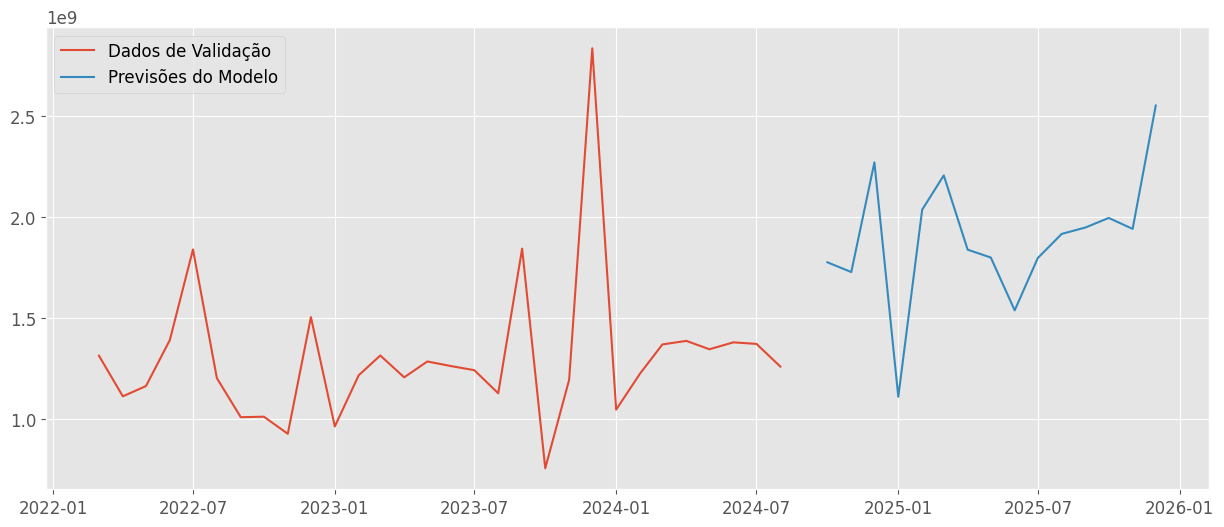

In [413]:
# Plot das Previsões
figure(figsize = (15, 6))
plt.plot(df_valid['VALOR_EMPENHADO'], label = 'Dados de Validação')
plt.plot(np.exp(previsoes[1:16]), label = 'Previsões do Modelo')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [414]:
# Buscar os últimos 24 meses dos dados de validação
df_valid_ultimos_24_meses = df_valid.tail(12)

In [415]:
df_valid_ultimos_24_meses.head()

,ANO_MES,VALOR_EMPENHADO,VALOR_EMPENHADO_log,previsoes_v1,previsoes_v2
ANO_MES,,,,,
2023-09-01,2023-09-01,1.843372e+09,21.334862,20.827327,21.204061
2023-10-01,2023-10-01,7.571976e+08,20.445135,20.827327,21.217681
2023-11-01,2023-11-01,1.194870e+09,20.901303,20.827327,21.231302
2023-12-01,2023-12-01,2.833930e+09,21.764930,20.827327,21.244922
2024-01-01,2024-01-01,1.047298e+09,20.769479,20.827327,21.258543


In [416]:
df_valid_ultimos_24_meses.tail()

,ANO_MES,VALOR_EMPENHADO,VALOR_EMPENHADO_log,previsoes_v1,previsoes_v2
ANO_MES,,,,,
2024-04-01,2024-04-01,1.387101e+09,21.050482,20.827327,21.299405
2024-05-01,2024-05-01,1.345654e+09,21.020146,20.827327,21.313026
2024-06-01,2024-06-01,1.379791e+09,21.045198,20.827327,21.326646
2024-07-01,2024-07-01,1.372170e+09,21.039659,20.827327,21.340267
2024-08-01,2024-08-01,1.260058e+09,20.954424,20.827327,21.353888


In [417]:
previsoes.head()

2024-09-01    21.273318
2024-10-01    21.297449
2024-11-01    21.269890
2024-12-01    21.542996
2025-01-01    20.828204
Freq: MS, Name: predicted_mean, dtype: float64

In [418]:
previsoes.shape

(17,)

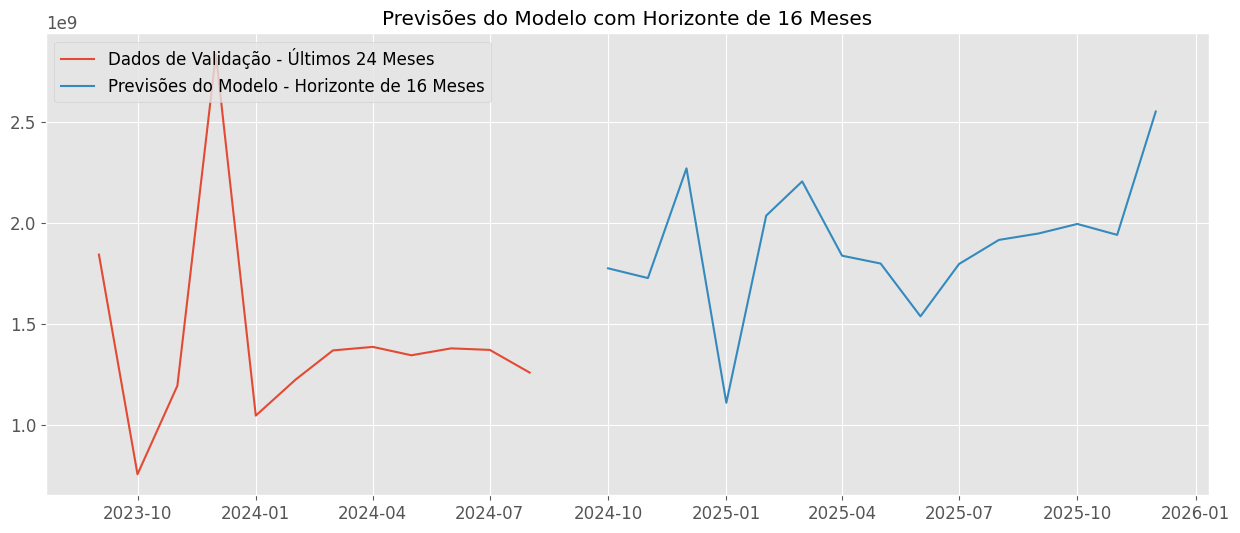

In [419]:
# Criamos uma nova série para as previsões com o índice correto
# O índice deve começar imediatamente após o último índice de df_valid_ultimas_120_horas
inicio_previsoes = df_valid_ultimos_24_meses.index[-1] + pd.Timedelta(hours = 1)
indice_previsoes = pd.date_range(start = inicio_previsoes, periods = len(previsoes[1:16]), freq = 'MS')
previsoes_series = pd.Series(np.exp(previsoes[1:16]))

# Plot das Previsões
figure(figsize = (15, 6))
plt.plot(df_valid_ultimos_24_meses['VALOR_EMPENHADO'], label = 'Dados de Validação - Últimos 24 Meses')
plt.plot(previsoes_series, label='Previsões do Modelo - Horizonte de 16 Meses')
plt.title('Previsões do Modelo com Horizonte de 16 Meses')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show();